In [1]:
%matplotlib inline

import arviz as az
import biom
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib import ticker
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import scipy.stats as ss
import seaborn as sns

from helper import tool_palette, tool_text_styling_dict

plt.style.use("./paper.mplstyle")

# Mouse Meta-Analysis

In [2]:
tbl = biom.load_table("../data/obesity/processed/mouse/tbl_merged.genus.biom")
tbl_df = tbl.to_dataframe(dense=True)
print(tbl_df.shape)
tbl_df.iloc[:5, :5]

(49, 153)


,S10422.11.F.17,S10422.12.F.17,S10422.13.F.17,S10422.14.F.17,S10422.16.F.17
g__02d06,1.0,0.0,24.0,1.0,0.0
g__Achromobacter,0.0,0.0,0.0,0.0,0.0
g__Acinetobacter,1.0,1.0,3.0,1.0,4.0
g__Adlercreutzia,67.0,140.0,41.0,2.0,38.0
g__Akkermansia,0.0,0.0,1.0,1.0,1.0


In [3]:
md = pd.read_table("../data/obesity/processed/mouse/metadata.merged.tsv", sep="\t", index_col=0)
depths = tbl_df.sum(axis=0)
md["depth"] = depths
md.head()

,host_subject_id,diet,variable_region,instrument,study_id,depth
S10422.11.F.17,md10422_Mouse_11,HFD,V4,Illumina,STUDY_10422,62936.0
S10422.12.F.17,md10422_Mouse_12,HFD,V4,Illumina,STUDY_10422,56892.0
S10422.13.F.17,md10422_Mouse_13,HFD,V4,Illumina,STUDY_10422,28712.0
S10422.14.F.17,md10422_Mouse_14,HFD,V4,Illumina,STUDY_10422,1995.0
S10422.16.F.17,md10422_Mouse_16,HFD,V4,Illumina,STUDY_10422,17228.0


In [4]:
md.groupby(["study_id", "diet"]).size()

study_id     diet    
STUDY_10422  HFD         20
STUDY_107    HFD         12
             Standard    15
STUDY_10856  HFD         14
             Standard    21
STUDY_11548  HFD         16
             Standard    12
STUDY_11829  HFD          8
             Standard     7
STUDY_12849  HFD          8
             Standard     8
STUDY_456    HFD          6
             Standard     6
dtype: int64

/home/grahman/miniconda3/envs/birdman-analyses-final/lib/python3.8/site-packages/gemelli/preprocessing.py:418: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(mat))


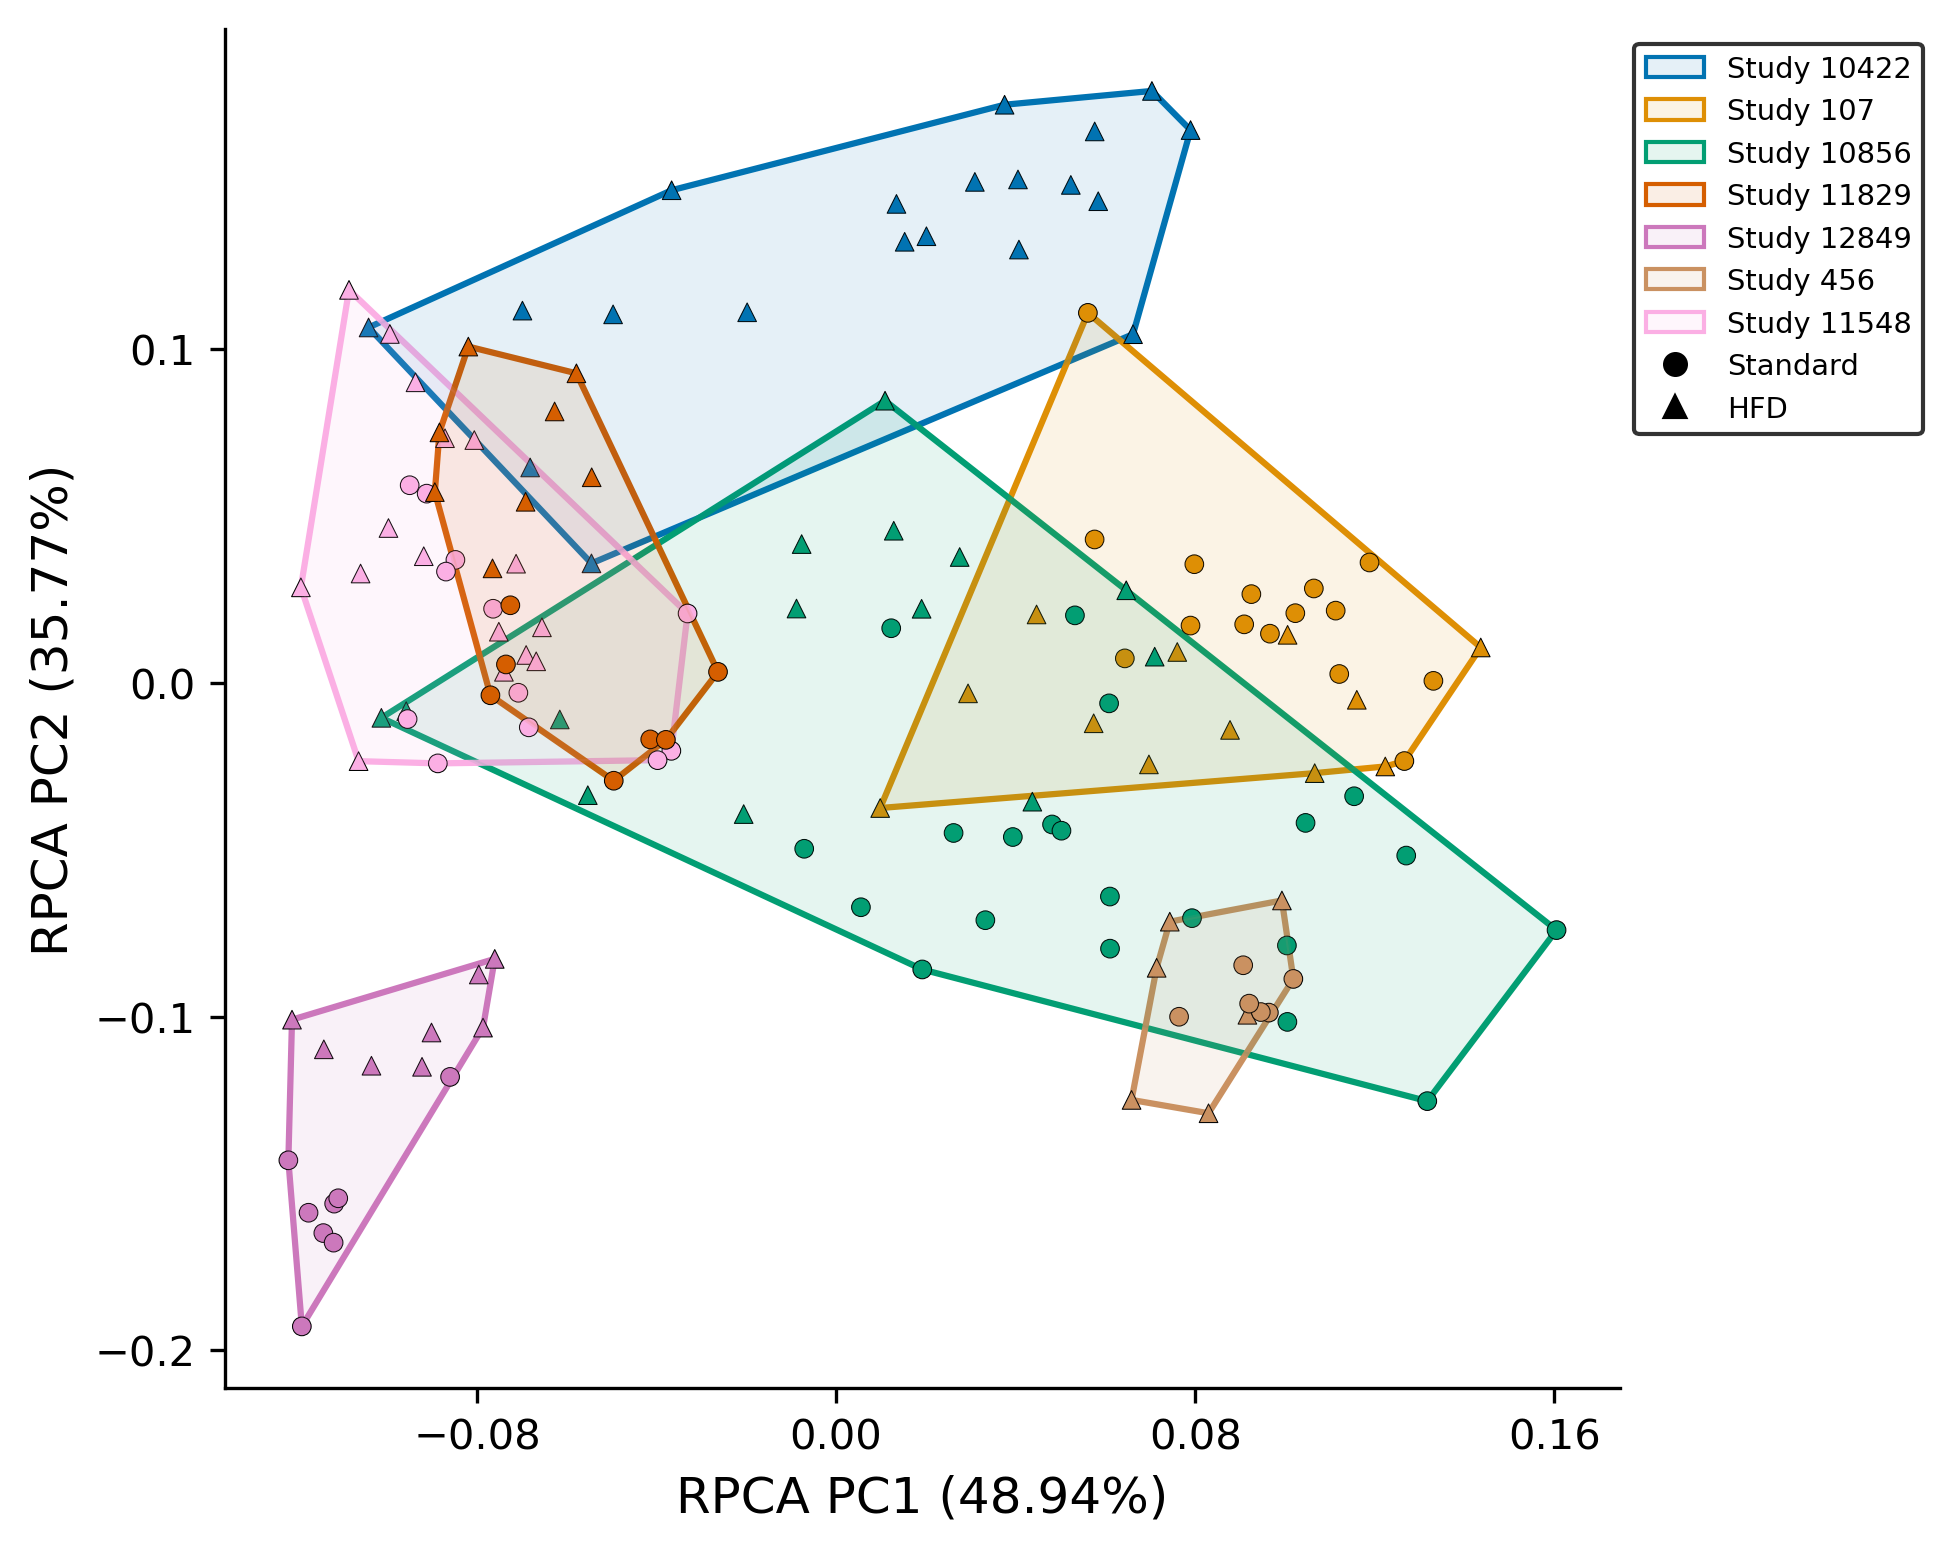

In [5]:
import scipy
from gemelli.rpca import rpca

ord_res, dm = rpca(tbl)
samp_axes = ord_res.samples.join(md)

studies = md["study_id"].unique()
pal = dict(zip(
    studies,
    sns.color_palette("colorblind", len(studies)).as_hex()
))
pal2 = dict(zip(
    studies,
    sns.color_palette("colorblind", len(studies))
))

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    
for bs, df in samp_axes.groupby("study_id"):
    color = pal.get(bs)
    df["color"] = color
        
    for diet, diet_df in df.groupby("diet"):
        if diet == "HFD":
            marker = "^"
        else:
            marker = "o"
            
        ax.scatter(
            x=diet_df["PC1"],
            y=diet_df["PC2"],
            s=20,
            marker=marker,
            c=diet_df["color"],
            edgecolor="black",
            linewidth=0.25,
        )
    
    points = df[["PC1", "PC2"]].values
    hull = scipy.spatial.ConvexHull(points)
    hull_plot_x = points[hull.vertices, 0]
    hull_plot_y = points[hull.vertices, 1]
    # Connect last point with first point
    hull_plot_x = np.append(hull_plot_x, points[hull.vertices[0], 0])
    hull_plot_y = np.append(hull_plot_y, points[hull.vertices[0], 1])

    ax.plot(
        hull_plot_x,
        hull_plot_y,
        c=color,
        zorder=0
    )
    ax.fill(
        points[hull.vertices, 0],
        points[hull.vertices, 1],
        c=color,
        alpha=0.1
    )

from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import re

study_regex = re.compile("STUDY_(\d+)")
handles  = []
for study in studies:
    label = study_regex.search(study).groups()[0]
    label = f"Study {label}"
    c = pal.get(study)
    _c = list(pal2.get(study)) + [0.1]
    study_patch = Patch(facecolor=_c, label=label, edgecolor=c)
    handles.append(study_patch)

nd_line = Line2D([0], [0], marker="o", label="Standard", color="black", lw=0, markersize=5)
hfd_line = Line2D([0], [0], marker="^", label="HFD", color="black", lw=0, markersize=5)
handles.extend([nd_line, hfd_line])
    
ax.legend(
    handles=handles,
    loc="upper left",
    edgecolor="black",
    bbox_to_anchor=[1, 1]
)

prop_1, prop_2, _ = [x * 100 for x in ord_res.proportion_explained]
ax.set_xlabel(f"RPCA PC1 ({prop_1:.2f}%)")
ax.set_ylabel(f"RPCA PC2 ({prop_2:.2f}%)")

ax.xaxis.set_major_locator(ticker.MaxNLocator(5))
ax.yaxis.set_major_locator(ticker.MaxNLocator(5))

plt.savefig("../figures/obesity/mouse_rpca.pdf")
plt.show()

In [6]:
md.groupby(["study_id"])["diet"].value_counts()

study_id     diet    
STUDY_10422  HFD         20
STUDY_107    Standard    15
             HFD         12
STUDY_10856  Standard    21
             HFD         14
STUDY_11548  HFD         16
             Standard    12
STUDY_11829  HFD          8
             Standard     7
STUDY_12849  HFD          8
             Standard     8
STUDY_456    HFD          6
             Standard     6
Name: diet, dtype: int64

In [7]:
md["diet"].value_counts()

HFD         84
Standard    69
Name: diet, dtype: int64

In [8]:
from skbio.stats.distance import permanova

print(permanova(dm, grouping=md, column="study_id"))

method name               PERMANOVA
test statistic name        pseudo-F
sample size                     153
number of groups                  7
test statistic              89.3899
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object


In [9]:
print(permanova(dm, grouping=md, column="diet"))

method name               PERMANOVA
test statistic name        pseudo-F
sample size                     153
number of groups                  2
test statistic              13.7121
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object


In [10]:
inf = az.from_netcdf("../results/obesity/mouse/inf.genus.mouse.nc")
inf.posterior

<xarray.Dataset>
Dimensions:     (chain: 4, draw: 500, feature: 49, study: 7, covariate: 3)
Coordinates:
  * chain       (chain) int64 0 1 2 3
  * draw        (draw) int64 0 1 2 3 4 5 6 7 ... 492 493 494 495 496 497 498 499
  * study       (study) object 'STUDY_10422' 'STUDY_107' ... 'STUDY_456'
  * covariate   (covariate) object 'Intercept' ... 'instrument[T.LS454]'
  * feature     (feature) object 'g__02d06' 'g__Achromobacter' ... 'g__rc4-4'
Data variables:
    base_phi    (feature, chain, draw) float64 ...
    study_disp  (feature, chain, draw, study) float64 ...
    study_re    (feature, chain, draw, study) float64 ...
    beta_var    (feature, chain, draw, covariate) float64 ...
Attributes:
    created_at:                 2022-08-23T17:51:57.606143
    arviz_version:              0.12.1
    inference_library:          cmdstanpy
    inference_library_version:  1.0.4

In [11]:
az.rhat(inf).max()

<xarray.Dataset>
Dimensions:     ()
Data variables:
    base_phi    float64 1.005
    study_disp  float64 1.008
    study_re    float64 1.027
    beta_var    float64 1.025

In [12]:
az.loo(inf, pointwise=True)

/home/grahman/miniconda3/envs/birdman-analyses-final/lib/python3.8/site-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 2000 posterior samples and 7497 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -18314.30   259.61
p_loo      319.48        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     7355   98.1%
 (0.5, 0.7]   (ok)        101    1.3%
   (0.7, 1]   (bad)        33    0.4%
   (1, Inf)   (very bad)    8    0.1%

In [13]:
non_intercept_covs = inf.posterior.coords["covariate"][1:].to_numpy()
beta_var = (
    inf.posterior["beta_var"].sel({"covariate": non_intercept_covs}) - 
    inf.posterior["beta_var"].sel({"covariate": non_intercept_covs}).mean(["feature", "chain", "draw"])
)

In [14]:
study_re = inf.posterior["study_re"]
study_re = study_re - study_re.mean(["feature", "chain", "draw"])
study_re.mean(["chain", "draw"]).to_pandas().head()

study,STUDY_10422,STUDY_107,STUDY_10856,STUDY_11548,STUDY_11829,STUDY_12849,STUDY_456
feature,,,,,,,
g__02d06,3.860150,-1.311305,-4.700911,0.660630,0.269840,-1.506343,-0.974709
g__Achromobacter,-1.354832,1.182448,1.937743,-1.951800,-0.890924,-2.536534,-1.436355
g__Acinetobacter,2.037876,1.128408,-2.394193,0.765871,-1.520286,-3.244475,-1.652572
g__Adlercreutzia,2.069138,0.743867,-0.716821,2.801517,3.209711,-6.020643,0.151715
g__Akkermansia,-4.288126,0.476465,0.620700,3.444727,4.571940,3.743366,-0.263660


In [15]:
diet_str = "C(diet, Treatment('Standard'))[T.HFD]"
diet_post = beta_var.sel({"covariate": diet_str})

In [16]:
diet_means = diet_post.mean(["chain", "draw"]).to_pandas().sort_values()
diet_stds = diet_post.std(["chain", "draw"]).to_pandas()

diet_values = pd.concat([diet_means, diet_stds], axis=1)
diet_values.columns = ["HFD_mean", "HFD_std"]
diet_values.head()

,HFD_mean,HFD_std
g__rc4-4,-3.118797,1.342766
g__Sarcandra,-2.518921,0.900563
g__Prevotella,-2.370651,0.945604
g__Anaerostipes,-1.553552,0.658979
g__Epulopiscium,-1.468688,0.932055


In [17]:
genus_counts = pd.read_table("../results/obesity/mouse/genus_counts.tsv", sep="\t", index_col=0)
genus_counts.head()

,count
g__02d06,1
g__Achromobacter,3
g__Acinetobacter,6
g__Adlercreutzia,13
g__Akkermansia,14


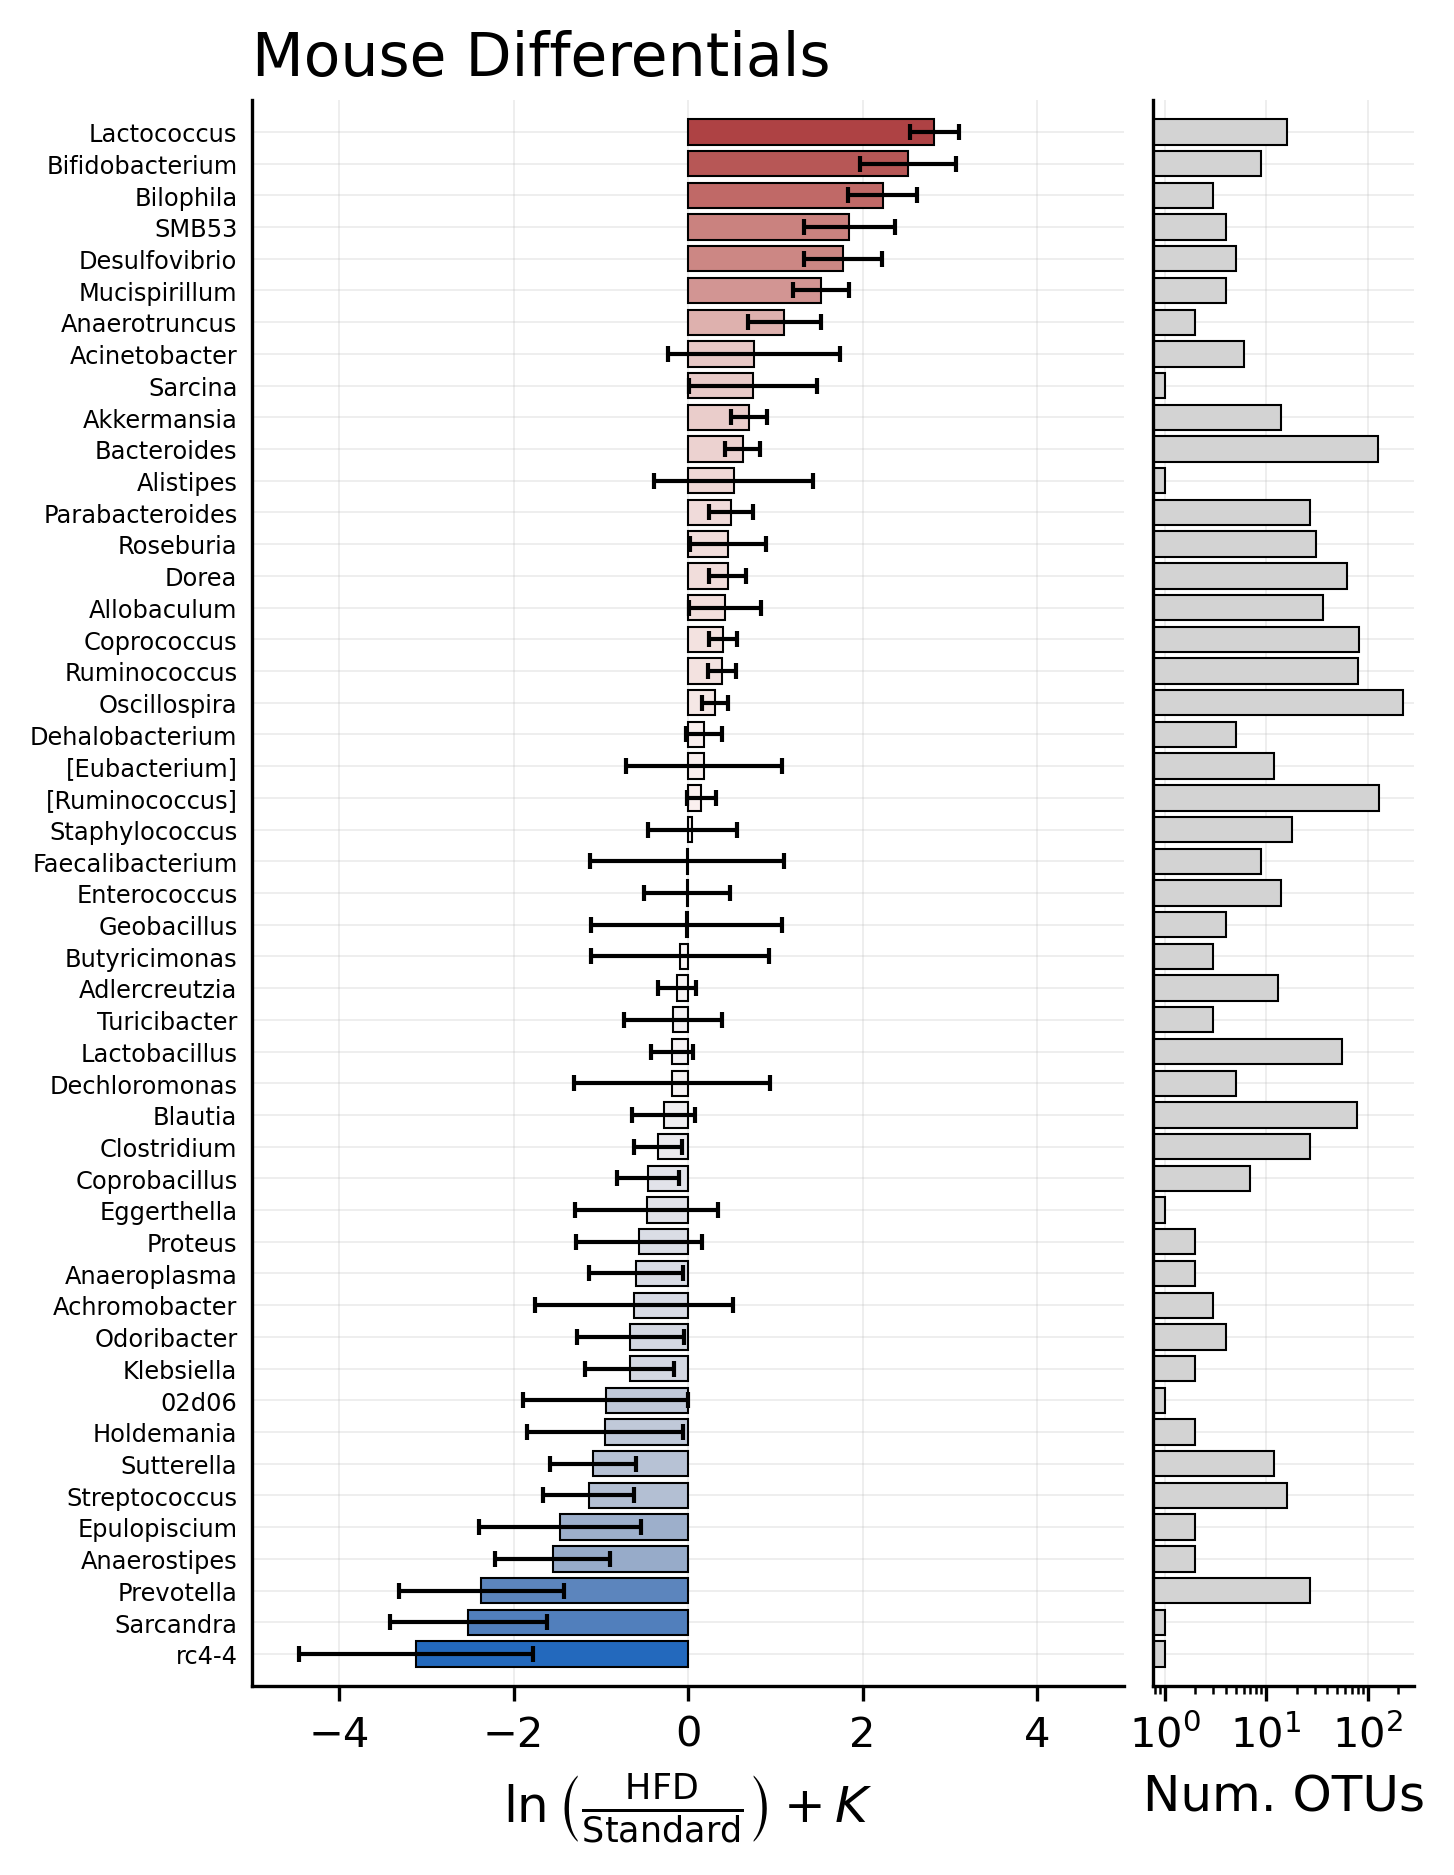

In [18]:
import matplotlib.ticker as mticker
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(5, 7))
gs = GridSpec(ncols=2, nrows=1, width_ratios=[1, 0.3], wspace=0.05)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

_counts = genus_counts.loc[diet_values.index]["count"]

x = np.arange(diet_values.shape[0])
cmap = sns.color_palette("vlag", as_cmap=True)
norm = Normalize(-3, 3)
bar_colors = cmap(norm(diet_values["HFD_mean"]))

ax1.barh(
    x,
    diet_values["HFD_mean"],
    xerr=diet_values["HFD_std"],
    color=bar_colors,
    edgecolor="black",
    lw=0.5,
    capsize=2,
    error_kw={"lw": 1, "capthick": 1}
)
ax1.set_xlim([-5, 5])

ax1.yaxis.set_major_locator(mticker.FixedLocator(x))
ax1.set_yticklabels(
    diet_means.index.str.replace("g__", ""),
    fontsize="xx-small"
)
ax1.tick_params("y", width=0, pad=0)
ax1.grid(linewidth=0.1)
ax1.set_ylim([-1, max(x)+1])
ax1.set_xlabel(r"$\ln\left(\frac{\mathrm{HFD}}{\mathrm{Standard}}\right) + K$")

ax2.barh(
    x,
    _counts,
    color="lightgray",
    edgecolor="black",
    lw=0.5
)
ax2.yaxis.set_major_locator(mticker.FixedLocator(x))
ax2.set_yticklabels([])
ax2.tick_params("y", width=0)
ax2.set_xscale("log")
ax2.set_ylim(ax1.get_ylim())
ax2.grid(lw=0.1)
ax2.set_xlabel("Num. OTUs")
ax1.set_title("Mouse Differentials")

plt.savefig("../figures/obesity/mouse_differentials.pdf")
plt.show()

In [19]:
region_map = {"V3": "orange", "V4": "purple"}
region_colors = md.groupby(["study_id"]).apply(lambda x: x["variable_region"].map(region_map)).droplevel(1)
region_colors = region_colors[~region_colors.index.duplicated()]
region_colors.name = "Variable Region"
region_colors

study_id
STUDY_10422    purple
STUDY_107      orange
STUDY_10856    purple
STUDY_11548    purple
STUDY_11829    purple
STUDY_12849    purple
STUDY_456      orange
Name: Variable Region, dtype: object

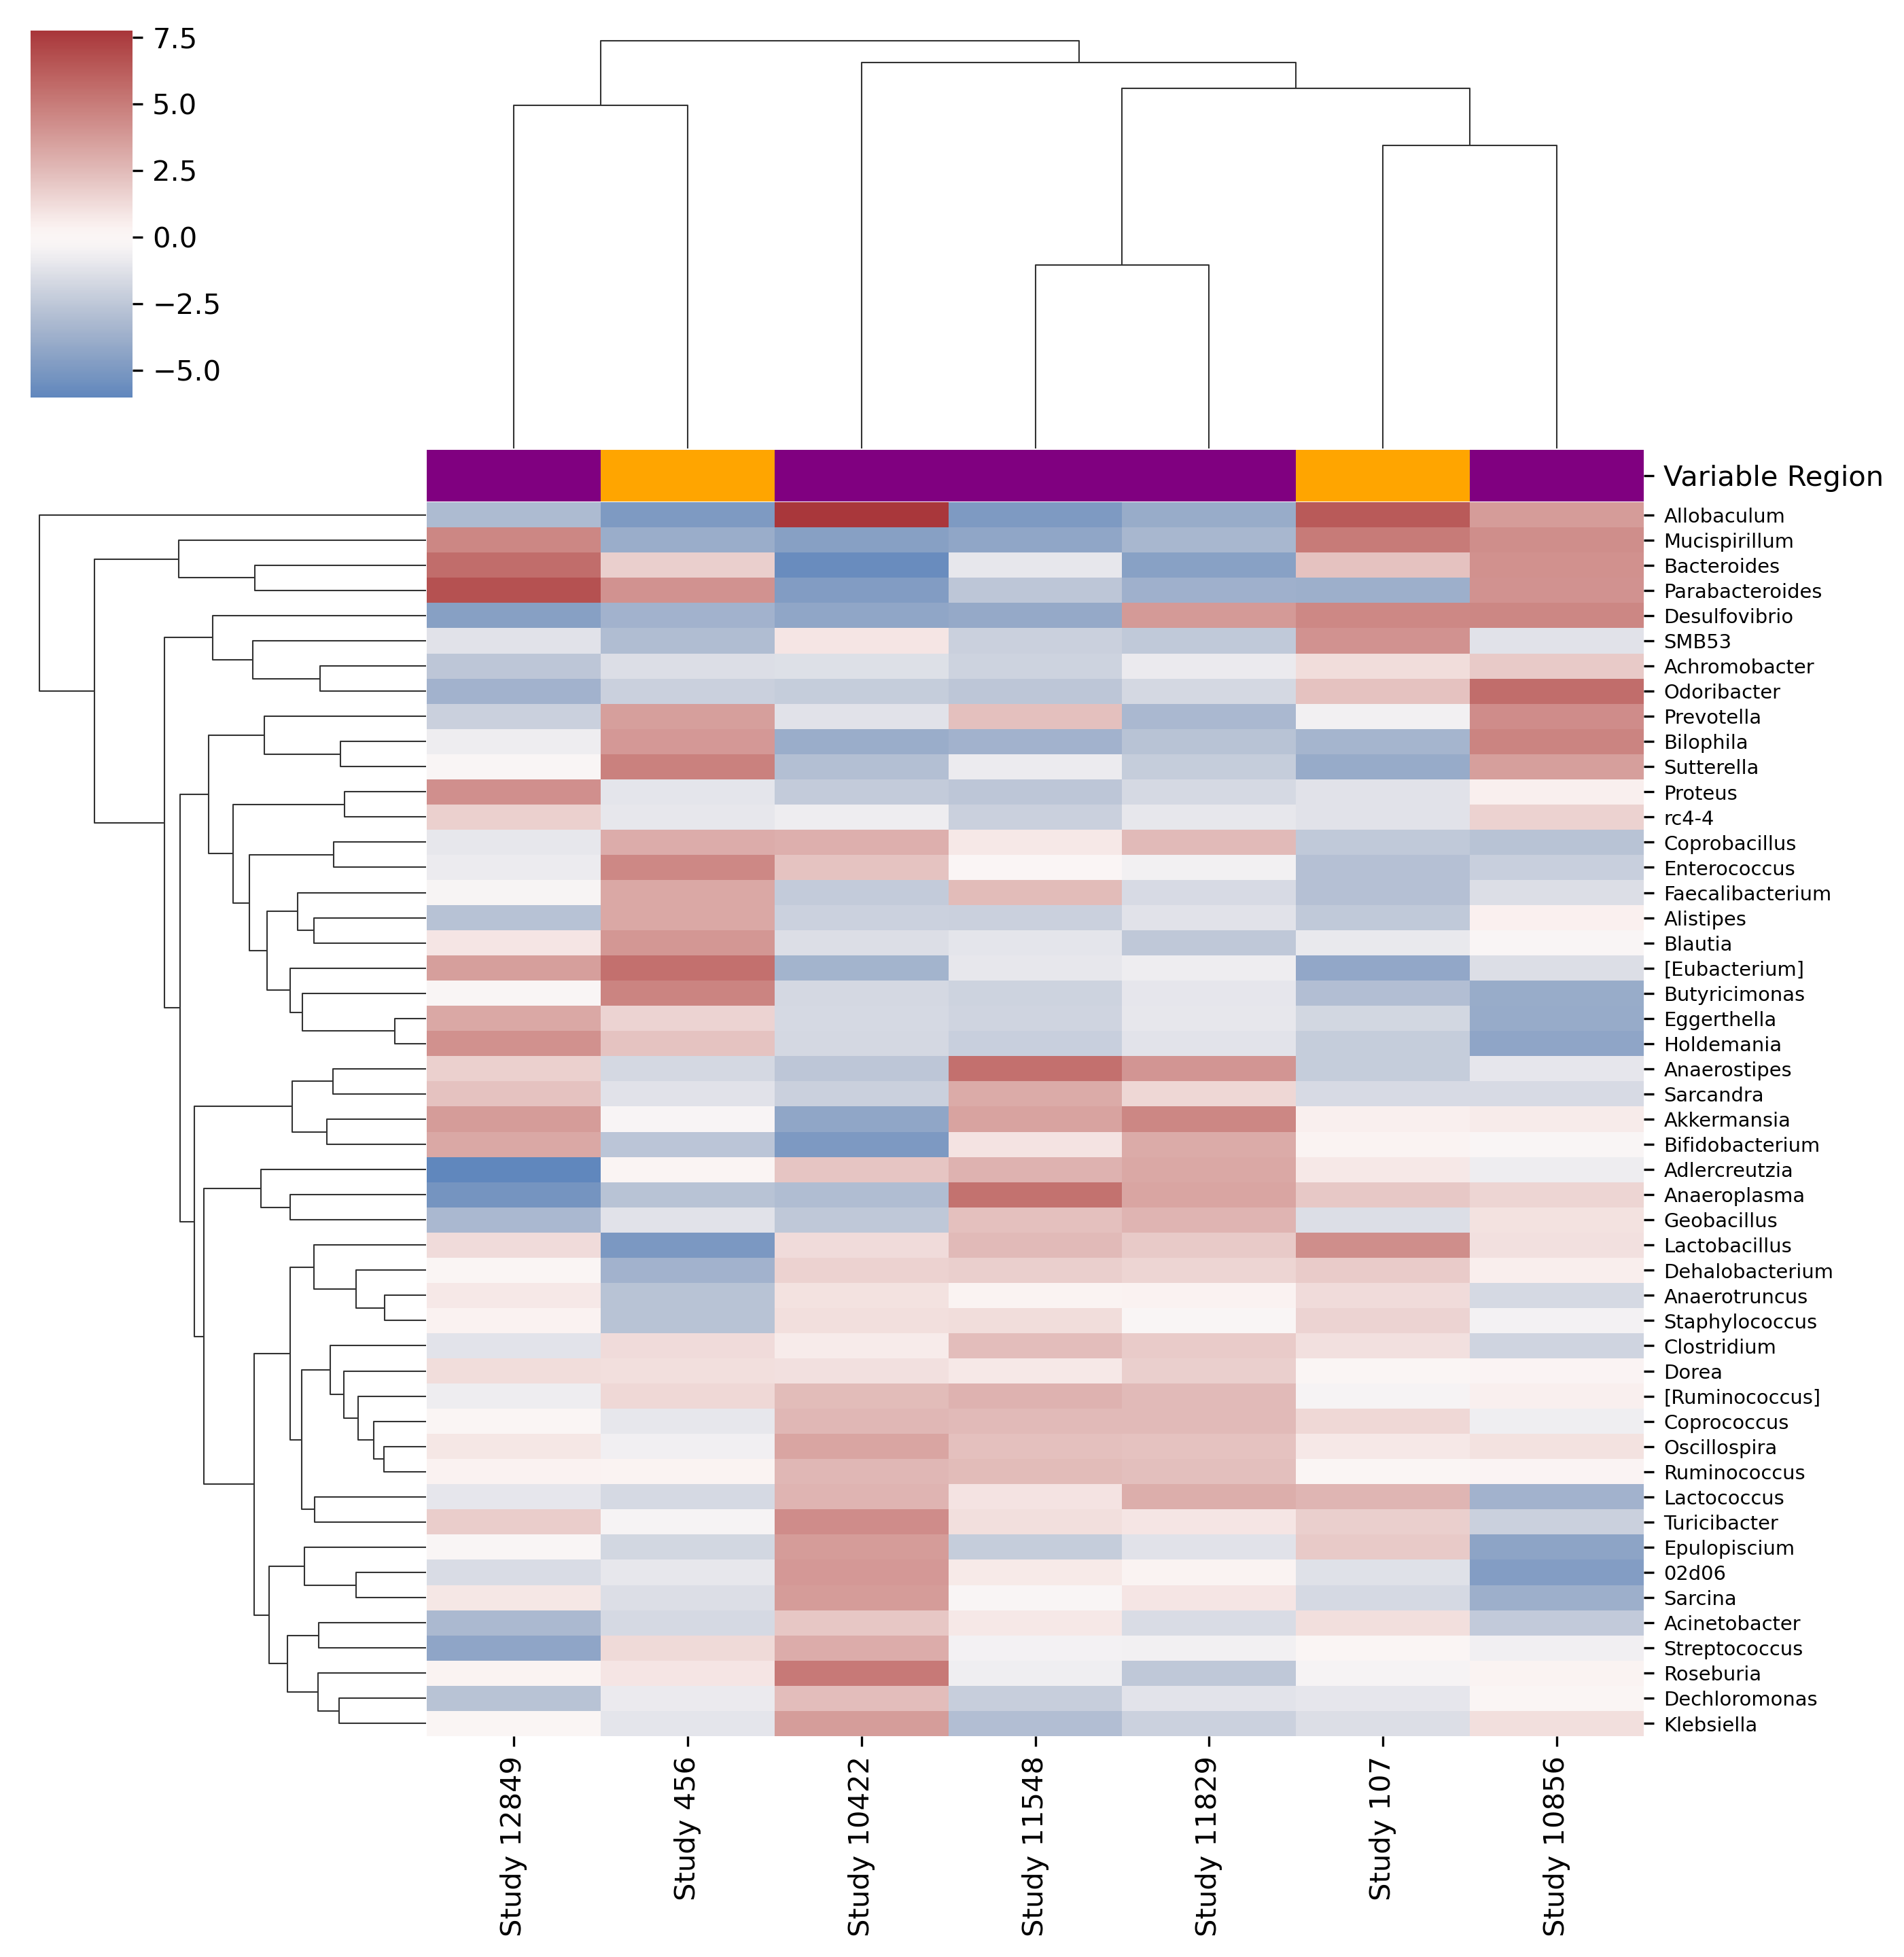

In [20]:
g = sns.clustermap(
    study_re.mean(["chain", "draw"]).to_pandas(),
    cmap="vlag",
    dendrogram_ratio=0.25,
    center=0,
    yticklabels=True,
    col_colors=region_colors,
)

hmap = g.ax_heatmap
hmap.set_yticklabels(
    [x._text.replace("g__", "") for x in hmap.get_yticklabels()],
    fontsize="x-small"
)
hmap.set_xticklabels(
    [x._text.replace("_", " ").title() for x in hmap.get_xticklabels()],
)
hmap.set(xlabel="", ylabel="")

plt.savefig("../figures/obesity/subj_random_slope_mean.pdf")
plt.show()

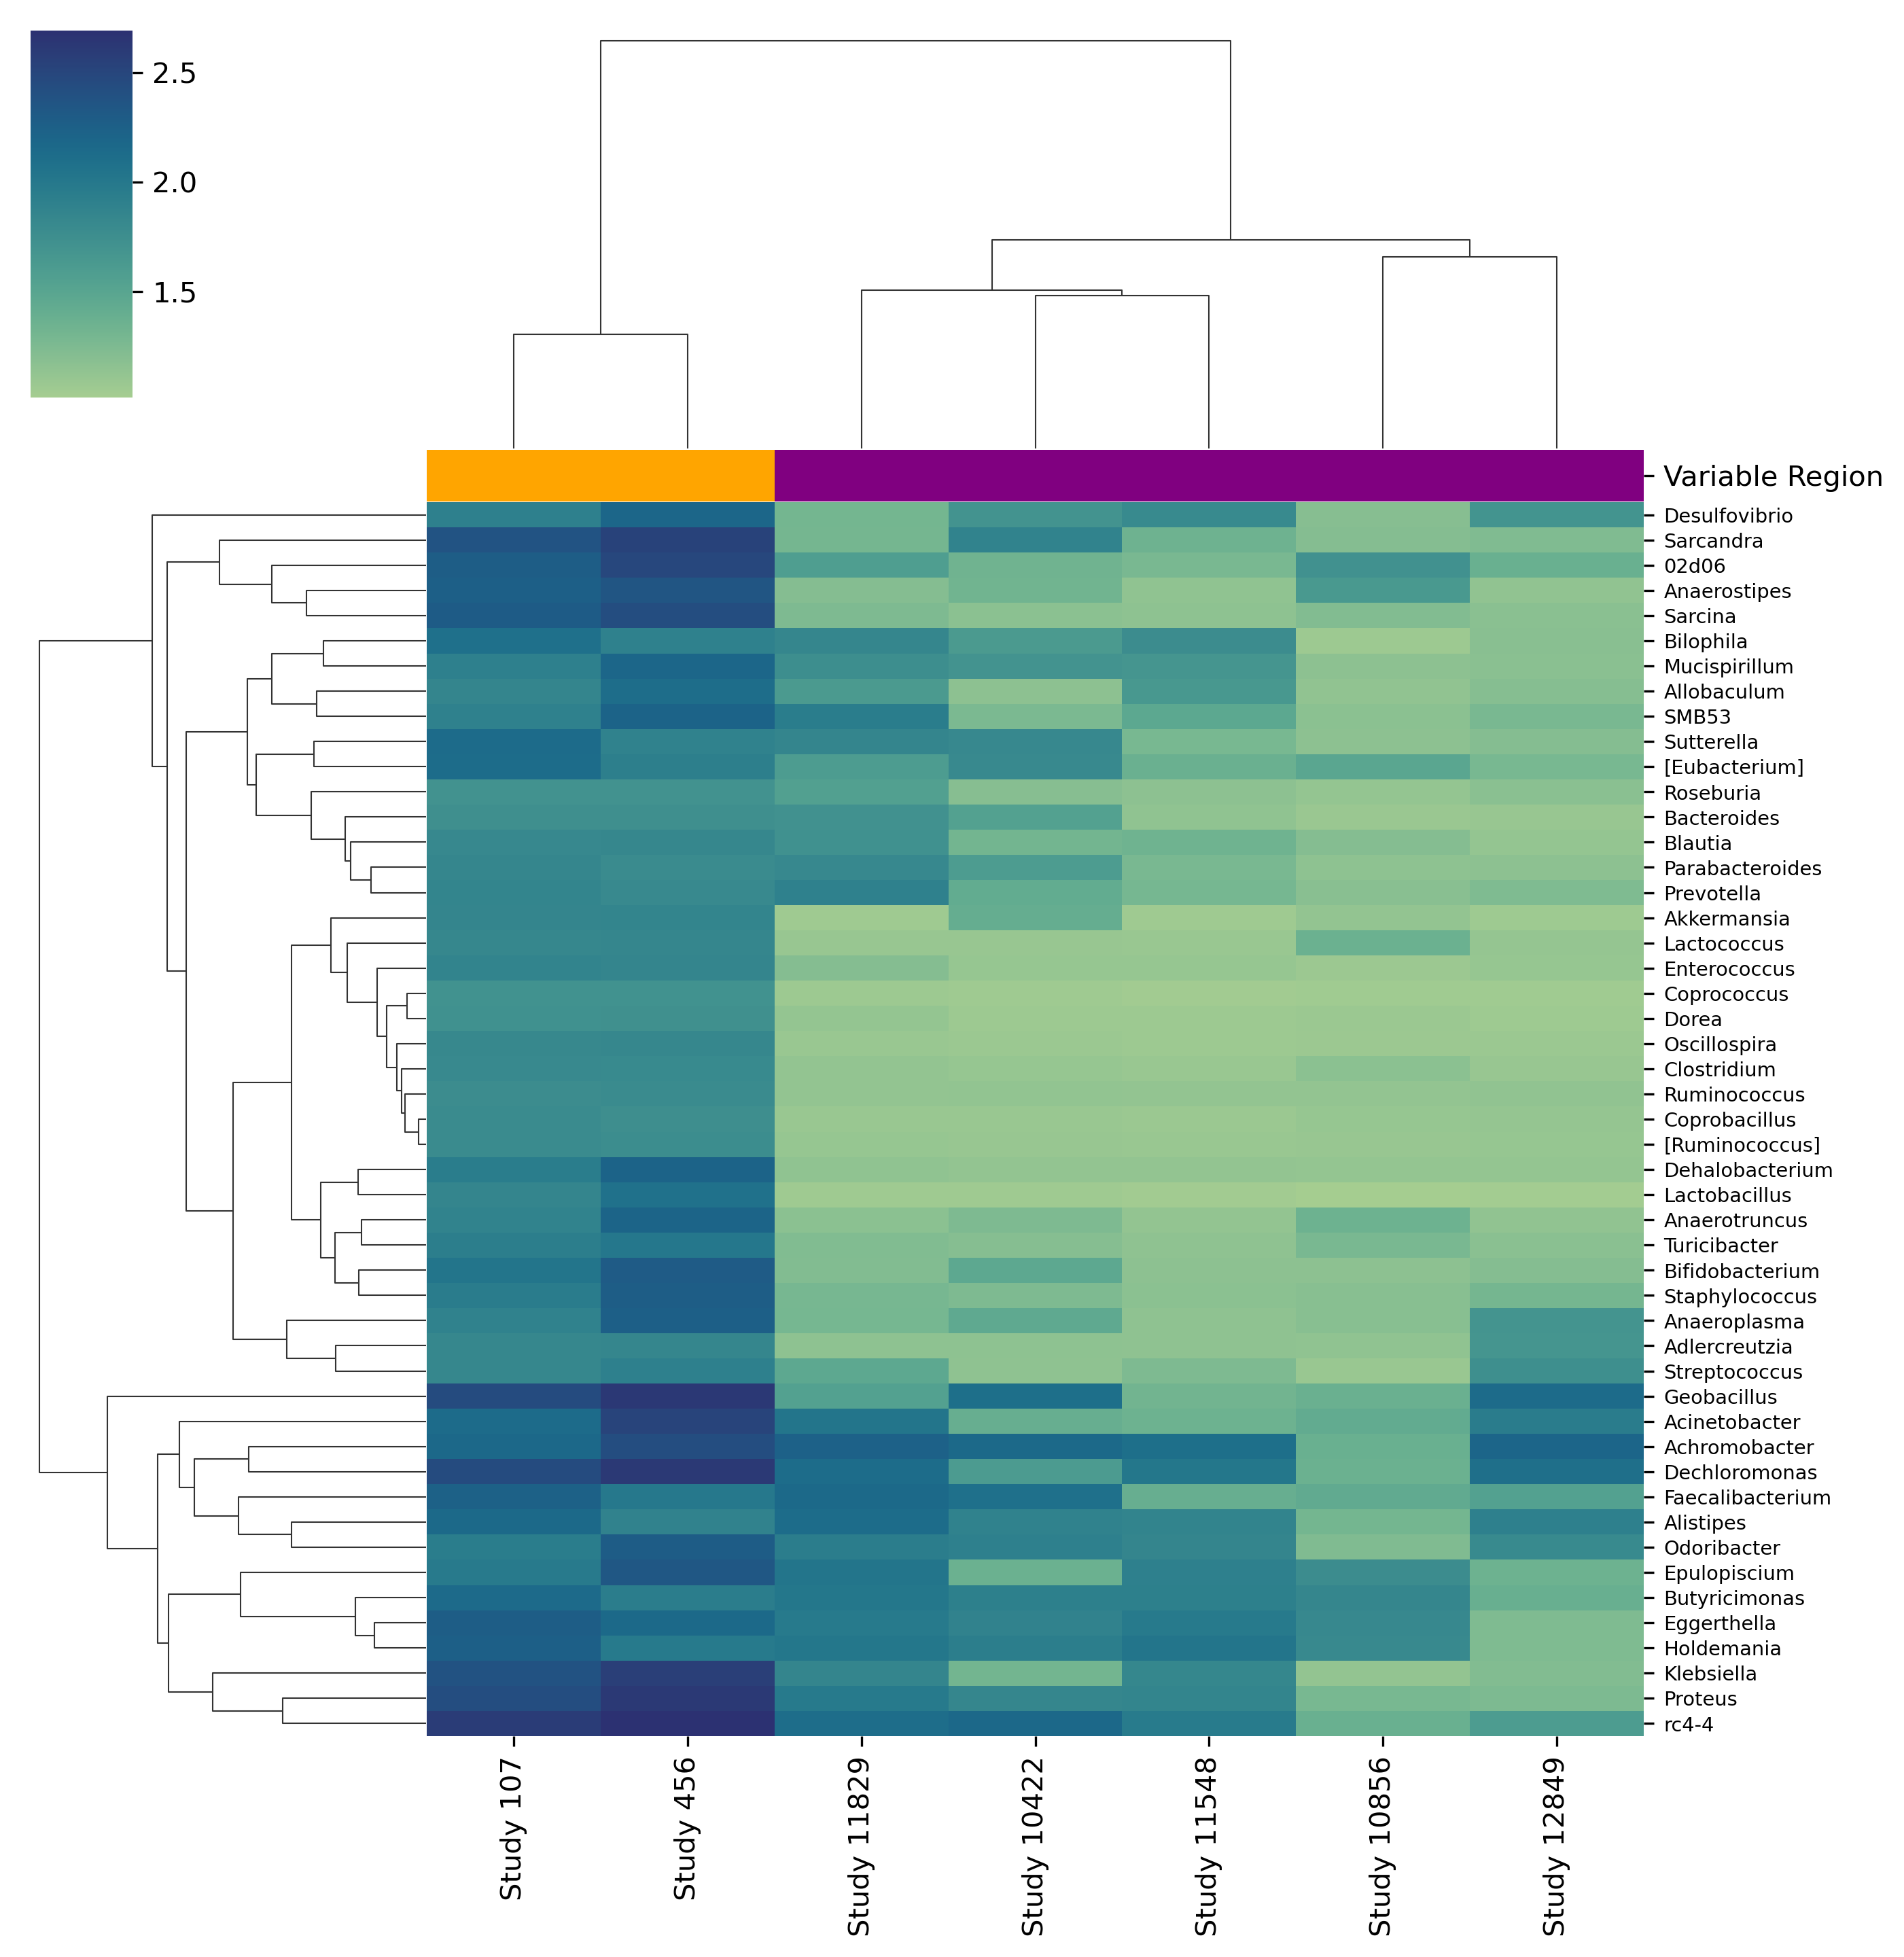

In [22]:
g = sns.clustermap(
    study_re.std(["chain", "draw"]).to_pandas(),
    cmap="crest",
    dendrogram_ratio=0.25,
    yticklabels=True,
    col_colors=region_colors
)
hmap = g.ax_heatmap
hmap.set_yticklabels(
    [x._text.replace("g__", "") for x in hmap.get_yticklabels()],
    fontsize="x-small"
)
hmap.set_xticklabels(
    [x._text.replace("_", " ").title() for x in hmap.get_xticklabels()],
)
hmap.set(xlabel="", ylabel="")

plt.savefig("../figures/obesity/subj_random_slope_std.pdf")
plt.show()

In [23]:
md.groupby(["instrument", "study_id"]).size()

instrument  study_id   
Illumina    STUDY_10422    20
            STUDY_10856    35
            STUDY_11548    28
            STUDY_11829    15
            STUDY_12849    16
LS454       STUDY_107      27
            STUDY_456      12
dtype: int64

In [24]:
aldex2_res = (
    pd.read_table("../results/obesity/mouse/aldex2_results.tsv", sep="\t", index_col=0)
    [["model.dietHFD Estimate", "model.dietHFD Pr(>|t|).BH"]]
    .rename(columns={"model.dietHFD Estimate": "aldex2_beta","model.dietHFD Pr(>|t|).BH": "aldex2_qval"})
    .sort_values(by="aldex2_beta")
)
aldex2_res.head()

,aldex2_beta,aldex2_qval
g__Prevotella,-3.750633,0.003227
g__Sutterella,-2.363975,0.119983
g__Bacteroides,-2.140247,0.682398
g__Parabacteroides,-1.946531,0.834747
g__Anaeroplasma,-1.746526,0.705574


In [25]:
ancombc_res = (
    pd.read_table("../results/obesity/mouse/ancombc_results.tsv", sep="\t", index_col=0)
    [["beta.dietHFD", "q_val.dietHFD"]]
    .rename(columns={"beta.dietHFD": "ancombc_beta", "q_val.dietHFD": "ancombc_qval"})
    .sort_values(by="ancombc_beta")
)
ancombc_res.head()

,ancombc_beta,ancombc_qval
g__Prevotella,-2.302502,0.000010
g__Sutterella,-1.301285,0.000212
g__Bacteroides,-1.210541,0.391450
g__Parabacteroides,-1.029627,0.800545
g__Anaerostipes,-1.001912,0.159856


In [26]:
deseq2_res = (
    pd.read_table("../results/obesity/mouse/deseq2_results.tsv", sep="\t", index_col=0)
    [["log2FoldChange", "padj"]]
    .rename(columns={"log2FoldChange": "deseq2_beta", "padj": "deseq2_qval"})
    .sort_values(by="deseq2_beta")
)
deseq2_res.head()

,deseq2_beta,deseq2_qval
g__Prevotella,-8.494628,1.066910e-31
g__Sutterella,-3.795885,2.595931e-06
g__Sarcandra,-3.535369,4.014243e-04
g__Odoribacter,-3.038138,1.421650e-02
g__rc4-4,-2.498234,2.070499e-01


In [27]:
tool_df = aldex2_res.join(ancombc_res).join(deseq2_res).join(diet_values[["HFD_mean"]])
tool_df = tool_df.rename(columns={"HFD_mean": "birdman_beta"})
tool_df.head()

,aldex2_beta,aldex2_qval,ancombc_beta,ancombc_qval,deseq2_beta,deseq2_qval,birdman_beta
g__Prevotella,-3.750633,0.003227,-2.302502,0.000010,-8.494628,1.066910e-31,-2.370651
g__Sutterella,-2.363975,0.119983,-1.301285,0.000212,-3.795885,2.595931e-06,-1.088961
g__Bacteroides,-2.140247,0.682398,-1.210541,0.391450,0.071887,9.993998e-01,0.623421
g__Parabacteroides,-1.946531,0.834747,-1.029627,0.800545,0.264855,9.310900e-01,0.492040
g__Anaeroplasma,-1.746526,0.705574,-0.965400,0.159856,-0.601948,6.969781e-01,-0.598829


In [28]:
(
    tool_df
    .filter(like="qval")
    .apply(lambda x: (x < 0.05).all(), axis=1)
    .where(lambda x: x)
    .dropna()
)

g__Prevotella      1.0
g__Oscillospira    1.0
g__Ruminococcus    1.0
g__Coprococcus     1.0
g__Lactococcus     1.0
dtype: float64

In [29]:
def tools_agree(row):
    return len(np.unique(row.values)) == 1
    
tool_agreement = (tool_df.filter(like="qval") < 0.05).apply(tools_agree, axis=1)
tool_agreement.value_counts()

True     38
False    11
dtype: int64

In [30]:
tool_agreement = (tool_df.filter(like="qval") < 0.05).all(axis=1)
tool_agreement = tool_agreement[tool_agreement]
tool_agreement

g__Prevotella      True
g__Oscillospira    True
g__Ruminococcus    True
g__Coprococcus     True
g__Lactococcus     True
dtype: bool

In [31]:
birdman_ranks = (
    inf.posterior["beta_var"]
    .sel({"covariate": "C(diet, Treatment('Standard'))[T.HFD]"})
    .stack(sample=["chain", "draw"])
    .to_pandas()
    .droplevel(0, axis=1)
    .rank(ascending=False)
    .reset_index()
    .melt(id_vars=["feature"])
    .drop(columns=["draw"])
)
birdman_ranks.head()

,feature,value
0,g__02d06,46.0
1,g__Achromobacter,39.0
2,g__Acinetobacter,27.0
3,g__Adlercreutzia,28.0
4,g__Akkermansia,9.0


In [32]:
other_tools = ["aldex2_beta", "ancombc_beta", "deseq2_beta"]

def is_birdman_opp_sign(row):
    other_tools_signs = np.sign(row[other_tools]).unique()
    if len(other_tools_signs) != 1:
        return False
    
    birdman_sign = np.sign(row["birdman_beta"])
    return birdman_sign != other_tools_signs.item()

birdman_opp_sign = tool_df.apply(lambda x: is_birdman_opp_sign(x), axis=1)
birdman_opp_sign[birdman_opp_sign]

g__Streptococcus    True
g__Epulopiscium     True
g__02d06            True
g__Coprobacillus    True
g__Turicibacter     True
g__Adlercreutzia    True
g__Enterococcus     True
dtype: bool

In [33]:
rank_df = tool_df.filter(like="beta").drop(columns=["birdman_beta"]).rank(ascending=False)

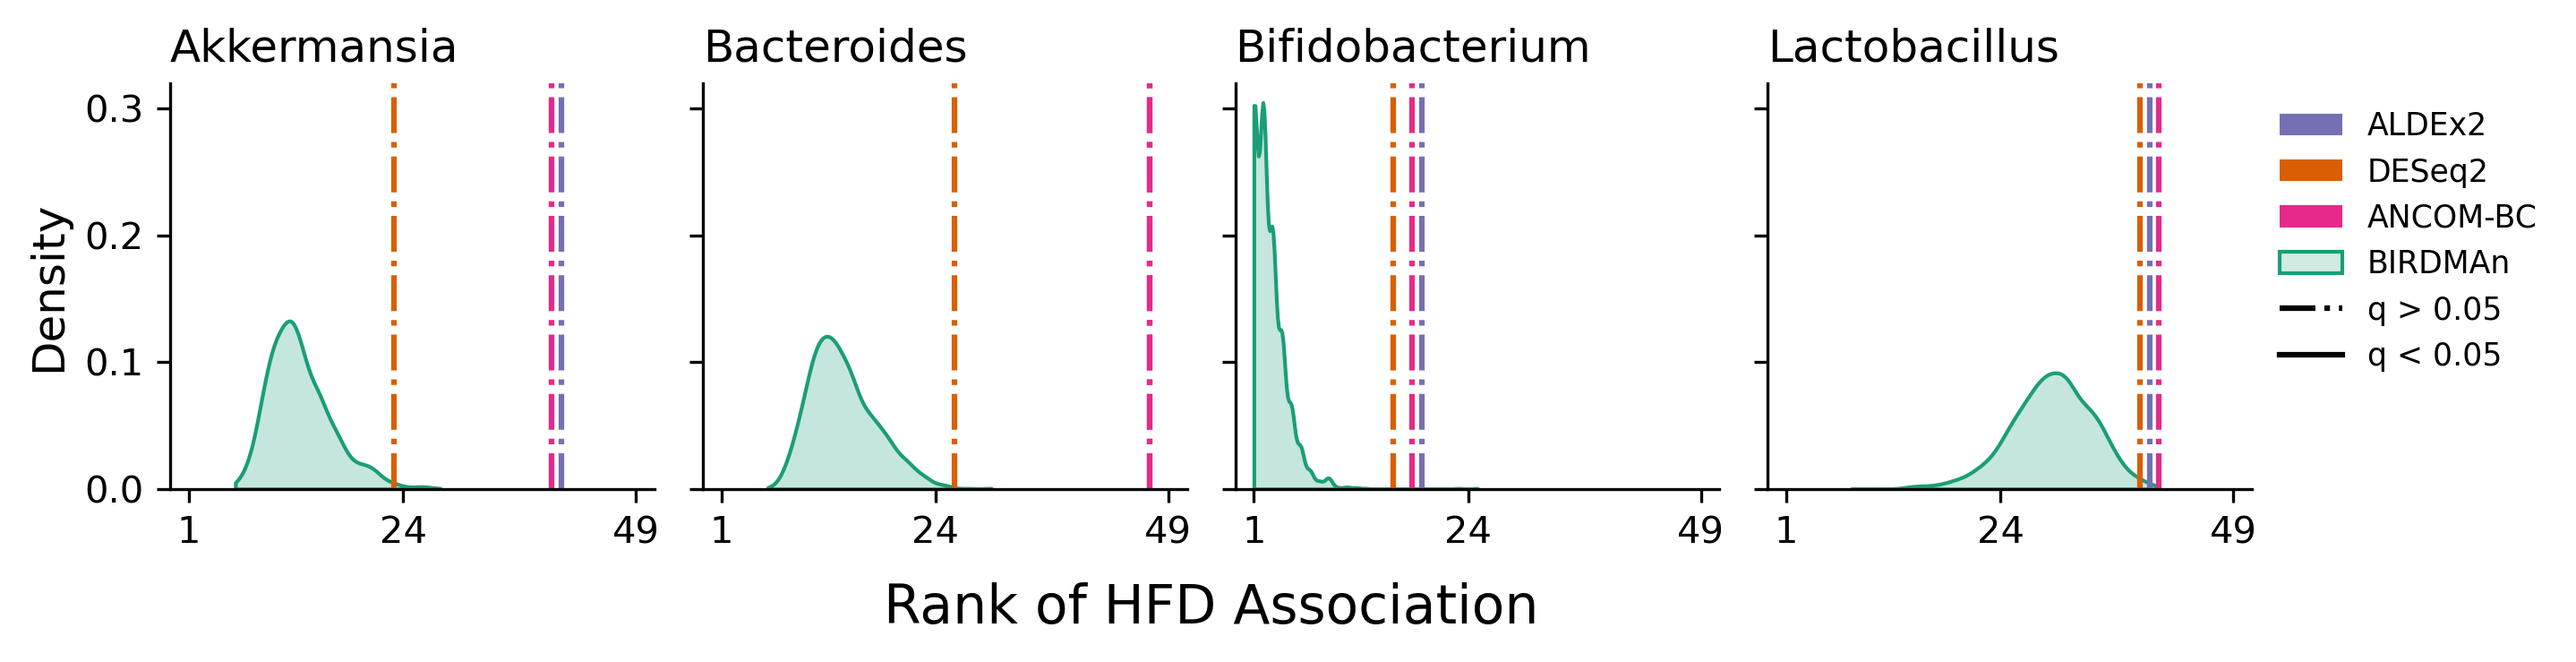

In [34]:
from matplotlib import ticker

genus_regex = re.compile("g__(\w+)")

_genera = ["g__Bacteroides", "g__Lactobacillus", "g__Akkermansia", "g__Bifidobacterium"]
_data = birdman_ranks[birdman_ranks["feature"].isin(_genera)]
n = rank_df.shape[0]

fig, axs = plt.subplots(1, len(_data["feature"].unique()), sharey=True, figsize=(10, 2))
plt.subplots_adjust(wspace=0.1)

big_ax = fig.add_subplot(111, zorder=-2)
big_ax.yaxis.set_visible(False)
big_ax.set_xticklabels([])
big_ax.set_xticks([])
big_ax.spines["left"].set_visible(False)
big_ax.spines["bottom"].set_visible(False)

handles = []
for i, (genus, _df) in enumerate(_data.groupby("feature")):
    ax = axs[i]
    sns.kdeplot(
        _df["value"],
        ax=ax,
        fill=True,
        color=tool_palette["BIRDMAn"],
        cut=0
    )
    
    for tool in ["aldex2", "deseq2", "ancombc"]:
        c = tool_palette[tool_text_styling_dict[tool]]
        _rank = rank_df.loc[genus, tool + "_beta"]        
        _qval = tool_df.loc[genus, tool + "_qval"]
        
        ls = "-" if _qval < 0.05 else "-."
        ax.axvline(_rank, color=c, ls=ls)
        ax.set_title(genus_regex.search(genus).groups()[0], fontsize="large")
        ax.set_xlabel("")
        
    ax.set_xticks([1, int(n/2), n])
    ax.set_xlim([-1, n+2])

for tool in ["aldex2", "deseq2", "ancombc"]:
    s = tool_text_styling_dict[tool]
    c = list(tool_palette[s])
    patch = Patch(facecolor=c, label=s)
    handles.append(patch)
    
c1 = list(tool_palette["BIRDMAn"])
c2 = list(tool_palette["BIRDMAn"]) + [0.2]
birdman_patch = Patch(facecolor=c2, label="BIRDMAn", edgecolor=c1)
handles.append(birdman_patch)

ns_line = Line2D([0], [0], label="q > 0.05", ls="-.", color="black")
s_line = Line2D([0], [0], label="q < 0.05", ls="-", color="black")
handles.extend([ns_line, s_line])
    
plt.legend(handles=handles, loc="upper left", bbox_to_anchor=[1, 1],
           frameon=False, fontsize="small")

big_ax.set_xlabel("Rank of HFD Association", labelpad=25, fontsize="x-large")

plt.savefig("../figures/obesity/rank_comparison.pdf")
plt.show()

In [35]:
tools = ["aldex2", "ancombc", "deseq2", "birdman"]
beta_cols = [x + "_beta" for x in tools]
tool_df.iloc[np.where(np.abs(np.sign(tool_df[beta_cols]).sum(axis=1)) != 4)].filter(like="beta")

,aldex2_beta,ancombc_beta,deseq2_beta,birdman_beta
g__Bacteroides,-2.140247,-1.210541,0.071887,0.623421
g__Parabacteroides,-1.946531,-1.029627,0.264855,0.492040
g__Akkermansia,-1.443630,-0.576685,0.230088,0.696502
g__Mucispirillum,-0.767930,-0.253960,0.991469,1.527092
g__Bilophila,-0.200992,0.082347,2.944202,2.229386
g__[Eubacterium],-0.016751,0.006193,0.999311,0.179293
g__Staphylococcus,0.039353,-0.062241,-0.015029,0.049187
g__Streptococcus,0.043285,0.018134,0.008183,-1.142076
g__Alistipes,0.120288,-0.019443,-0.090384,0.520787
g__Geobacillus,0.176787,0.018843,-0.819702,-0.020598


In [36]:
tool_df.rank().iloc[np.where((tool_df.filter(like="qval") < 0.05).all(axis=1))].filter(like="beta")

,aldex2_beta,ancombc_beta,deseq2_beta,birdman_beta
g__Prevotella,1.0,1.0,1.0,3.0
g__Oscillospira,40.0,43.0,32.0,31.0
g__Ruminococcus,43.0,45.0,33.0,32.0
g__Coprococcus,44.0,47.0,37.0,33.0
g__Lactococcus,49.0,49.0,49.0,49.0


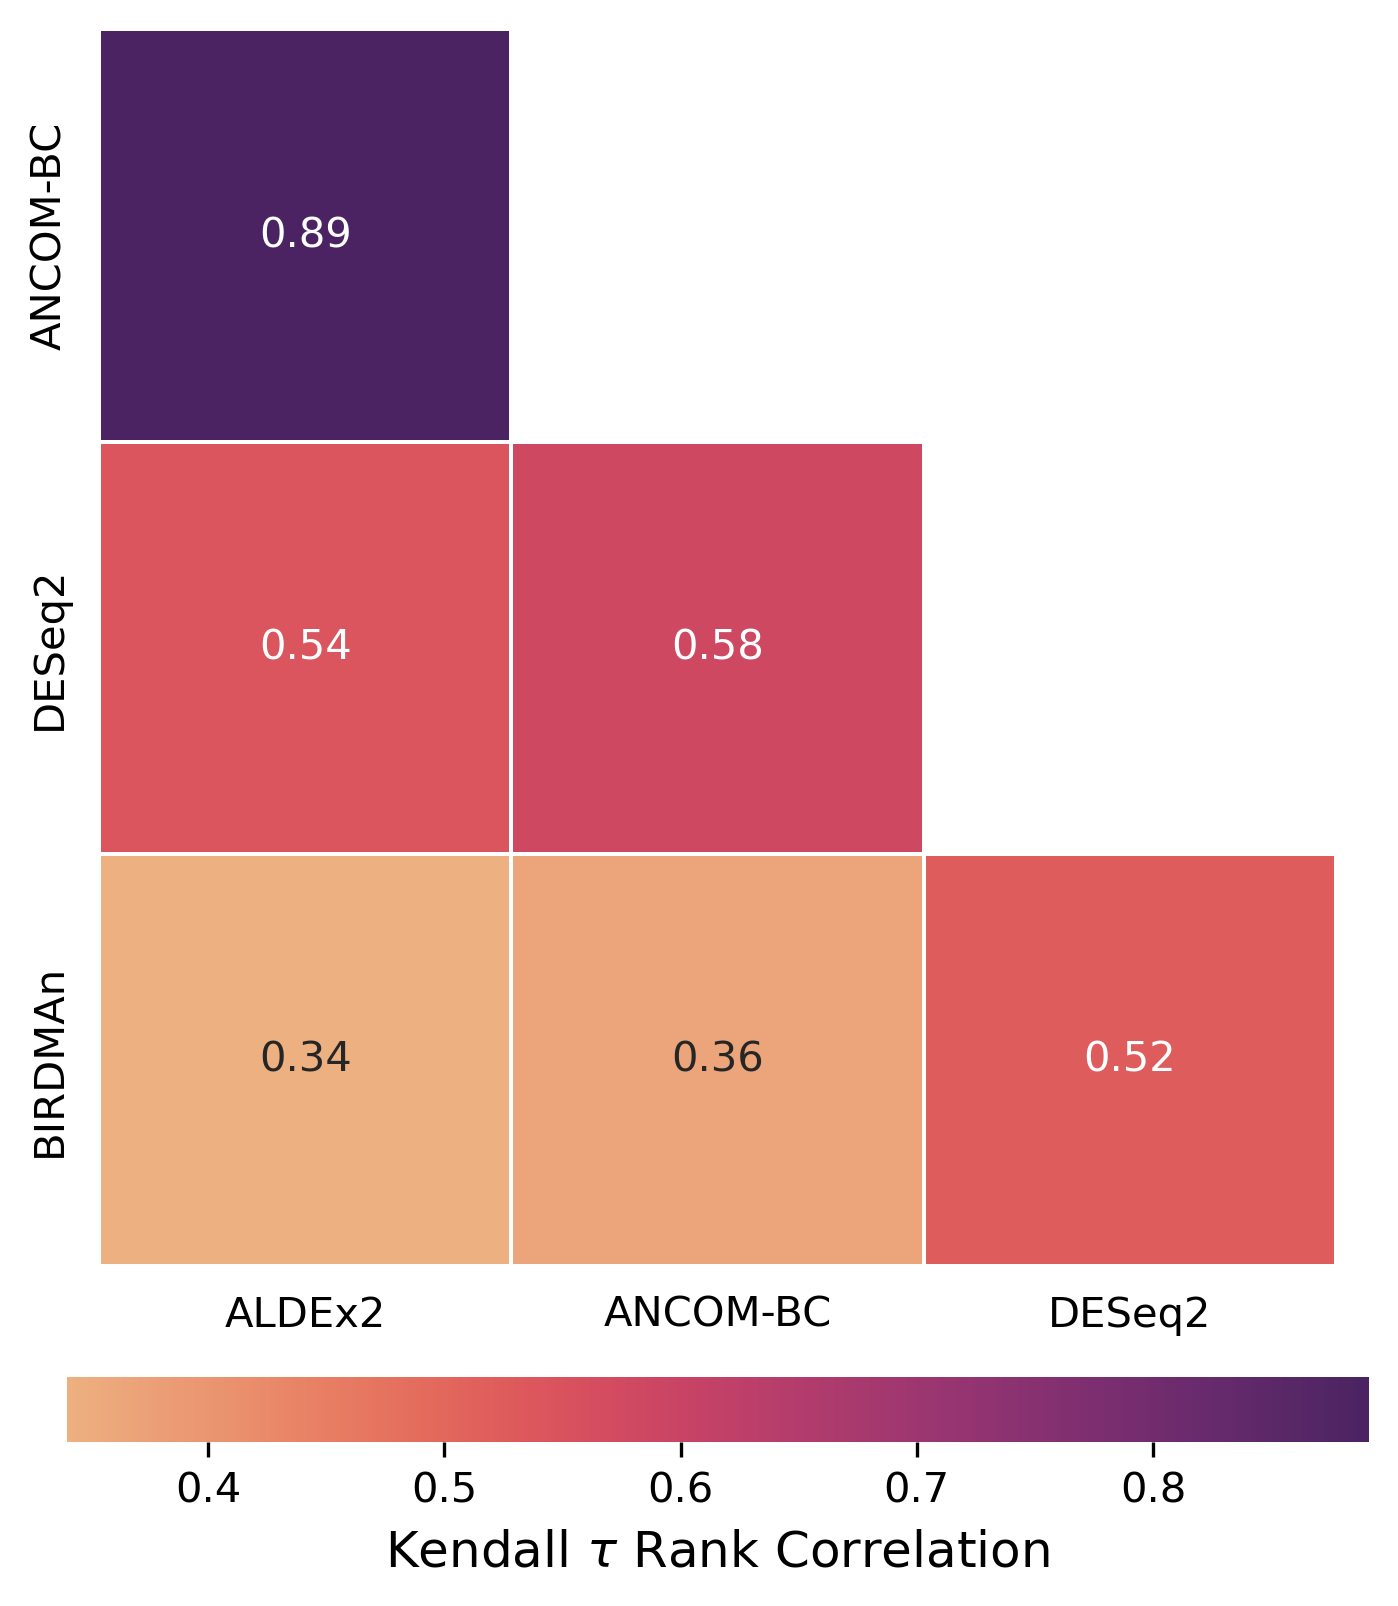

In [37]:
corr_mat = tool_df.filter(like="beta").corr(lambda a, b: ss.kendalltau(a, b).correlation)
corr_mat.index = corr_mat.index.map(lambda x: tool_text_styling_dict[x[:x.index("_")]])
corr_mat.columns = corr_mat.columns.map(lambda x: tool_text_styling_dict[x[:x.index("_")]])
corr_mat = corr_mat.iloc[1:, :-1]

mask = np.zeros_like(corr_mat)
mask[np.triu_indices_from(mask, 1)] = True

f, ax = plt.subplots(figsize=(7, 7))
ax = sns.heatmap(
    corr_mat,
    mask=mask,
    square=True,
    annot=True,
    linewidths=0.5,
    cmap="flare",
    fmt=".2f",
    cbar_kws={
        "label": r"Kendall $\tau$ Rank Correlation",
        "orientation": "horizontal",
        "shrink": 0.8,
        "pad": 0.07
    }
)
ax.tick_params("both", width=0)

plt.savefig("../figures/obesity/mouse_kendall.pdf")
plt.show()

In [38]:
def log_ratio(table, top_feats, bot_feats, md=md):
    num_sum = table.loc[:, top_feats].sum(axis=1)
    denom_sum = table.loc[:, bot_feats].sum(axis=1)
    lr_df = pd.concat([num_sum, denom_sum], axis=1)
    lr_df.columns = ["num", "denom"]
    lr_df = lr_df.dropna(how="all")
    bad_idx = lr_df[(lr_df["num"] == 0) & (lr_df["denom"] == 0)].index
    lr_df = lr_df.drop(index=bad_idx)
    lr_df = lr_df + 1
    lr_df["log_ratio"] = np.log(lr_df["num"]/lr_df["denom"]).to_frame()
    lr_df = lr_df.join(md)
    return lr_df

In [39]:
from collections import defaultdict
from sklearn.metrics import roc_curve, auc, average_precision_score

lr_df_list = []
pval_dict = defaultdict(dict)
ap_dict = defaultdict(dict)
auc_dict = defaultdict(dict)
shared_genera_dict = defaultdict(dict)
feat_dict_last = defaultdict(dict)

_df = tool_df.filter(like="beta")
for n in range(1, 11):
    shared_top_genera_set = set()
    shared_bot_genera_set = set()
    for col in _df.columns:
        _vals = tool_df[col].sort_values()
        top_n = _vals.tail(n).index
        bot_n = _vals.head(n).index
        
        shared_top_genera_set.update(set(top_n))
        shared_bot_genera_set.update(set(bot_n))

        tool_name = re.search("(\w*)_beta", col).groups()[0]
        tool_name = tool_text_styling_dict[tool_name]
        feat_dict_last[tool_name]["top"] = top_n
        feat_dict_last[tool_name]["bot"] = bot_n
        
        lr_df = log_ratio(tbl_df.T, top_n, bot_n)
        lr_df_list.append(
            lr_df[["log_ratio", "study_id", "diet"]]
            .assign(Tool=tool_name, N=n)
        )
        stat, p = (
            ss.ttest_ind(
                *lr_df.groupby(["diet"])
                ["log_ratio"]
                .apply(lambda x: x.values), alternative="greater"
            )
        )
        neg_log10_p = -np.log10(p)

        pval_dict[col][n] = p
        
        fpr, tpr, thresh = roc_curve(lr_df["diet"], lr_df["log_ratio"], pos_label="HFD")
        auc_dict[col][n] = auc(fpr, tpr)
        ap_dict[col][n] = average_precision_score(lr_df["diet"], lr_df["log_ratio"], pos_label="HFD")
        
    shared_genera_dict[n]["top"] = shared_top_genera_set
    shared_genera_dict[n]["bottom"] = shared_bot_genera_set
    
pval_df = (
    pd.DataFrame.from_dict(pval_dict)
    .reset_index()
    .melt(id_vars=["index"])
    .assign(Tool=lambda x: x["variable"].str.extract("(\w+)_beta"))
    .assign(Tool=lambda x: x["Tool"].map(tool_text_styling_dict))
    .rename(columns={"value": "p"})
    .assign(neg_log10_p=lambda x: -np.log10(x["p"]))
)
pval_df.tail()

,index,variable,p,Tool,neg_log10_p
35,6,birdman_beta,5.773875e-15,BIRDMAn,14.238533
36,7,birdman_beta,1.269448e-14,BIRDMAn,13.896385
37,8,birdman_beta,1.786612e-14,BIRDMAn,13.747970
38,9,birdman_beta,2.648385e-14,BIRDMAn,13.577019
39,10,birdman_beta,1.750733e-13,BIRDMAn,12.756780


In [40]:
auc_df = (
    pd.DataFrame(auc_dict)
    .reset_index()
    .melt(id_vars=["index"])
    .assign(Tool=lambda x: x["variable"].str.extract("(\w+)_beta"))
    .assign(Tool=lambda x: x["Tool"].map(tool_text_styling_dict))
    .rename(columns={"value": "AUC"})
)
auc_df.head()

,index,variable,AUC,Tool
0,1,aldex2_beta,0.786922,ALDEx2
1,2,aldex2_beta,0.796153,ALDEx2
2,3,aldex2_beta,0.743271,ALDEx2
3,4,aldex2_beta,0.745945,ALDEx2
4,5,aldex2_beta,0.758109,ALDEx2


In [41]:
ap_df = (
    pd.DataFrame(ap_dict)
    .reset_index()
    .melt(id_vars=["index"])
    .assign(Tool=lambda x: x["variable"].str.extract("(\w+)_beta"))
    .assign(Tool=lambda x: x["Tool"].map(tool_text_styling_dict))
    .rename(columns={"value": "Average Precision"})
)
ap_df.head()

,index,variable,Average Precision,Tool
0,1,aldex2_beta,0.842142,ALDEx2
1,2,aldex2_beta,0.845270,ALDEx2
2,3,aldex2_beta,0.814385,ALDEx2
3,4,aldex2_beta,0.814044,ALDEx2
4,5,aldex2_beta,0.808857,ALDEx2


In [42]:
auc_df.groupby("Tool")["AUC"].agg(["mean", "median", "std"])

,mean,median,std
Tool,,,
ALDEx2,0.730349,0.741805,0.048656
ANCOM-BC,0.711888,0.706090,0.044450
BIRDMAn,0.834607,0.832286,0.014487
DESeq2,0.788458,0.787267,0.006499


In [43]:
pval_df.groupby("Tool")["neg_log10_p"].agg(["mean", "median", "std"])

,mean,median,std
Tool,,,
ALDEx2,8.083557,7.932637,2.246033
ANCOM-BC,7.231882,7.405373,2.164131
BIRDMAn,14.060130,13.822177,1.766025
DESeq2,11.006546,11.193487,0.515622


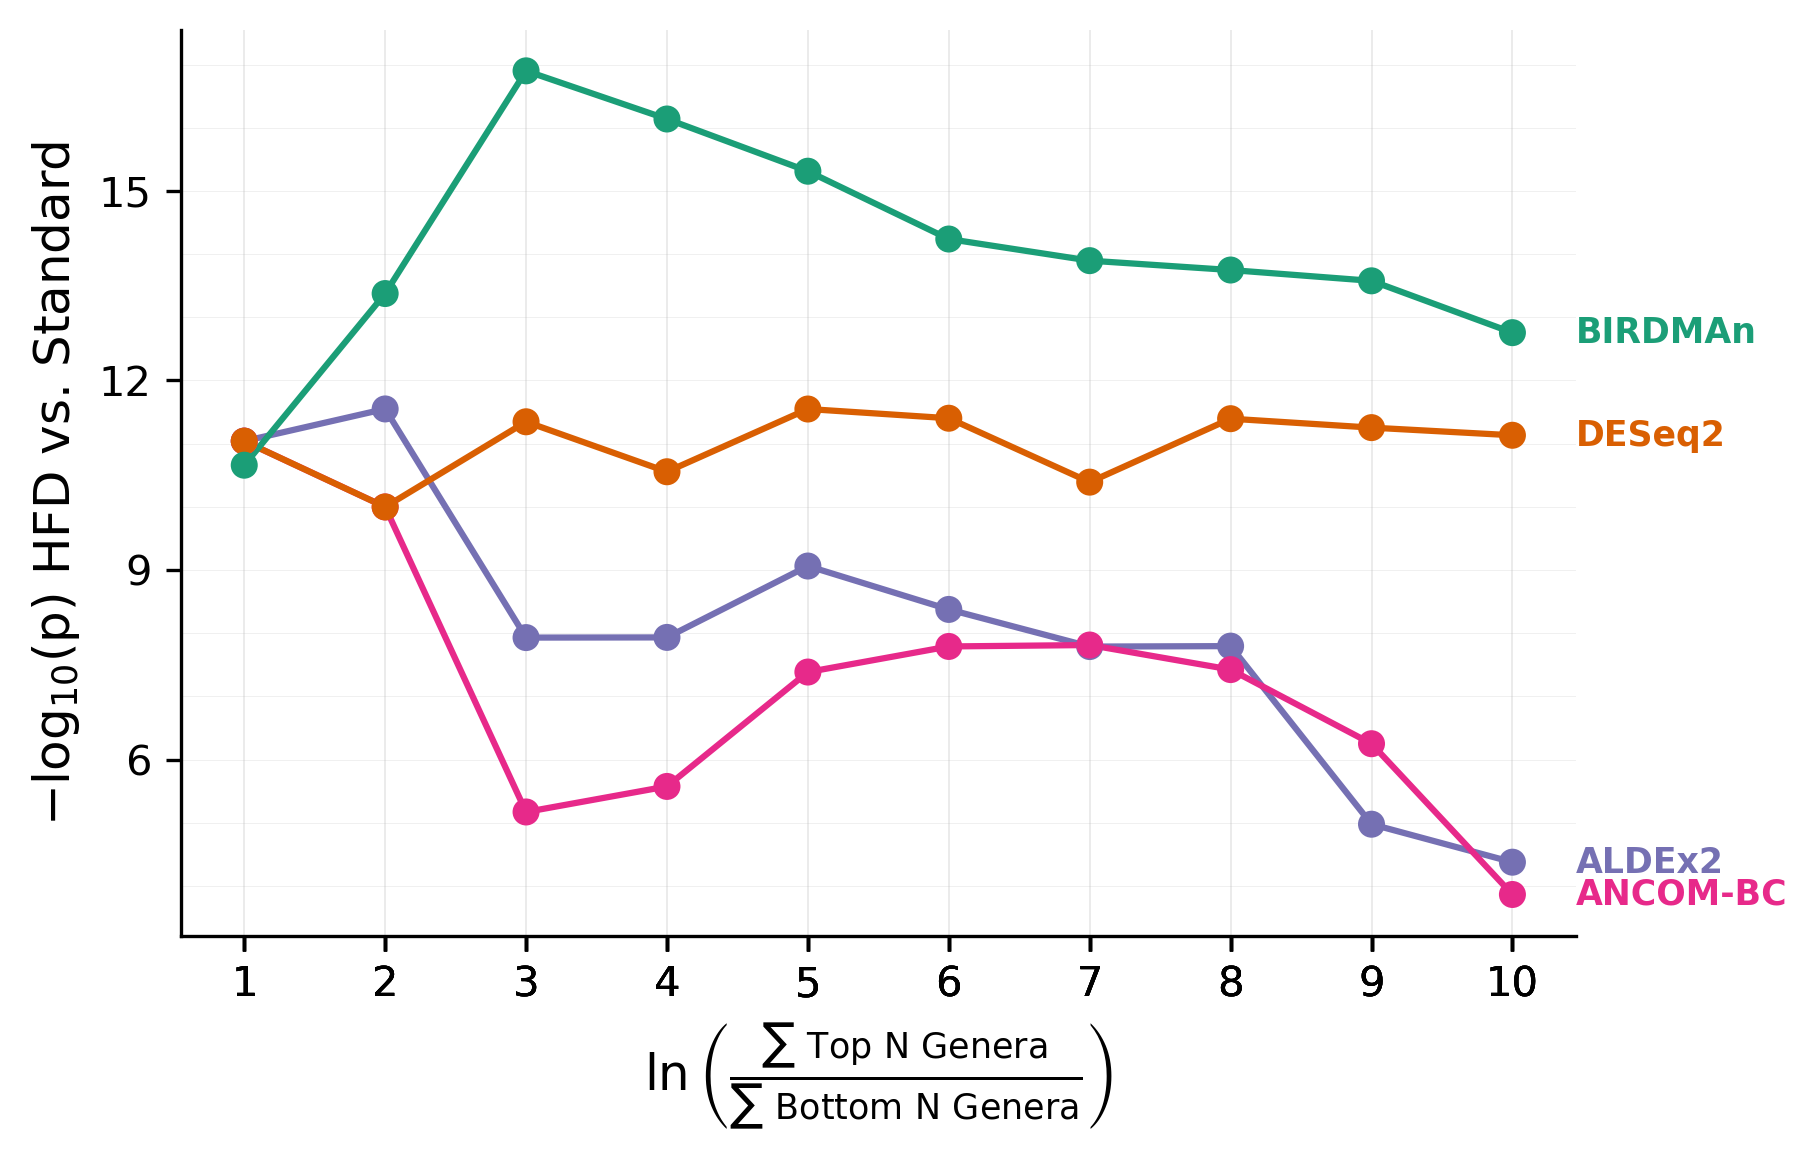

In [44]:
from matplotlib.gridspec import GridSpec
from matplotlib import ticker

fig, ax = plt.subplots(1, 1)

args = {
    "data": pval_df,
    "x": "index",
    "y": "neg_log10_p",
    "hue": "Tool",
    "palette": tool_palette,
    "ax": ax,
    "legend": False
}
sns.scatterplot(**args, edgecolor=None, zorder=2)
sns.lineplot(**args, zorder=1)

ax.set_xlabel(r"$\ln\left(\frac{\sum\ \mathrm{Top\ N\ Genera}}{\sum\ \mathrm{Bottom\ N\ Genera}}\right)$")
ax.set_ylabel(r"$-\log_{10}(\mathrm{p})$ HFD vs. Standard")

last_idx = pval_df["index"].max()
x_max = ax.get_xlim()[1]
for tool, c in tool_palette.items():
    last_val = (
        pval_df[(pval_df["Tool"] == tool) & (pval_df["index"] == last_idx)]
        ["neg_log10_p"]
        .item()
    )
    ax.text(
        x=x_max,
        y=last_val,
        s=tool,
        fontsize="small",
        ha="left",
        va="center",
        c=c,
        weight="bold"
    )
    
ax.set_xticks(pval_df["index"])
ax.yaxis.set_major_locator(ticker.MaxNLocator(5))
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(3))

x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()
x_range = x_max - x_min
y_range = y_max - y_min

ax.grid(axis="x", alpha=0.3, linewidth=x_range*0.01)
ax.grid(axis="y", alpha=0.3, linewidth=y_range*0.01, which="both")
ax.tick_params("y", width=0, which="minor")

plt.savefig("../figures/obesity/pval_mouse_autoselection.pdf")
plt.show()

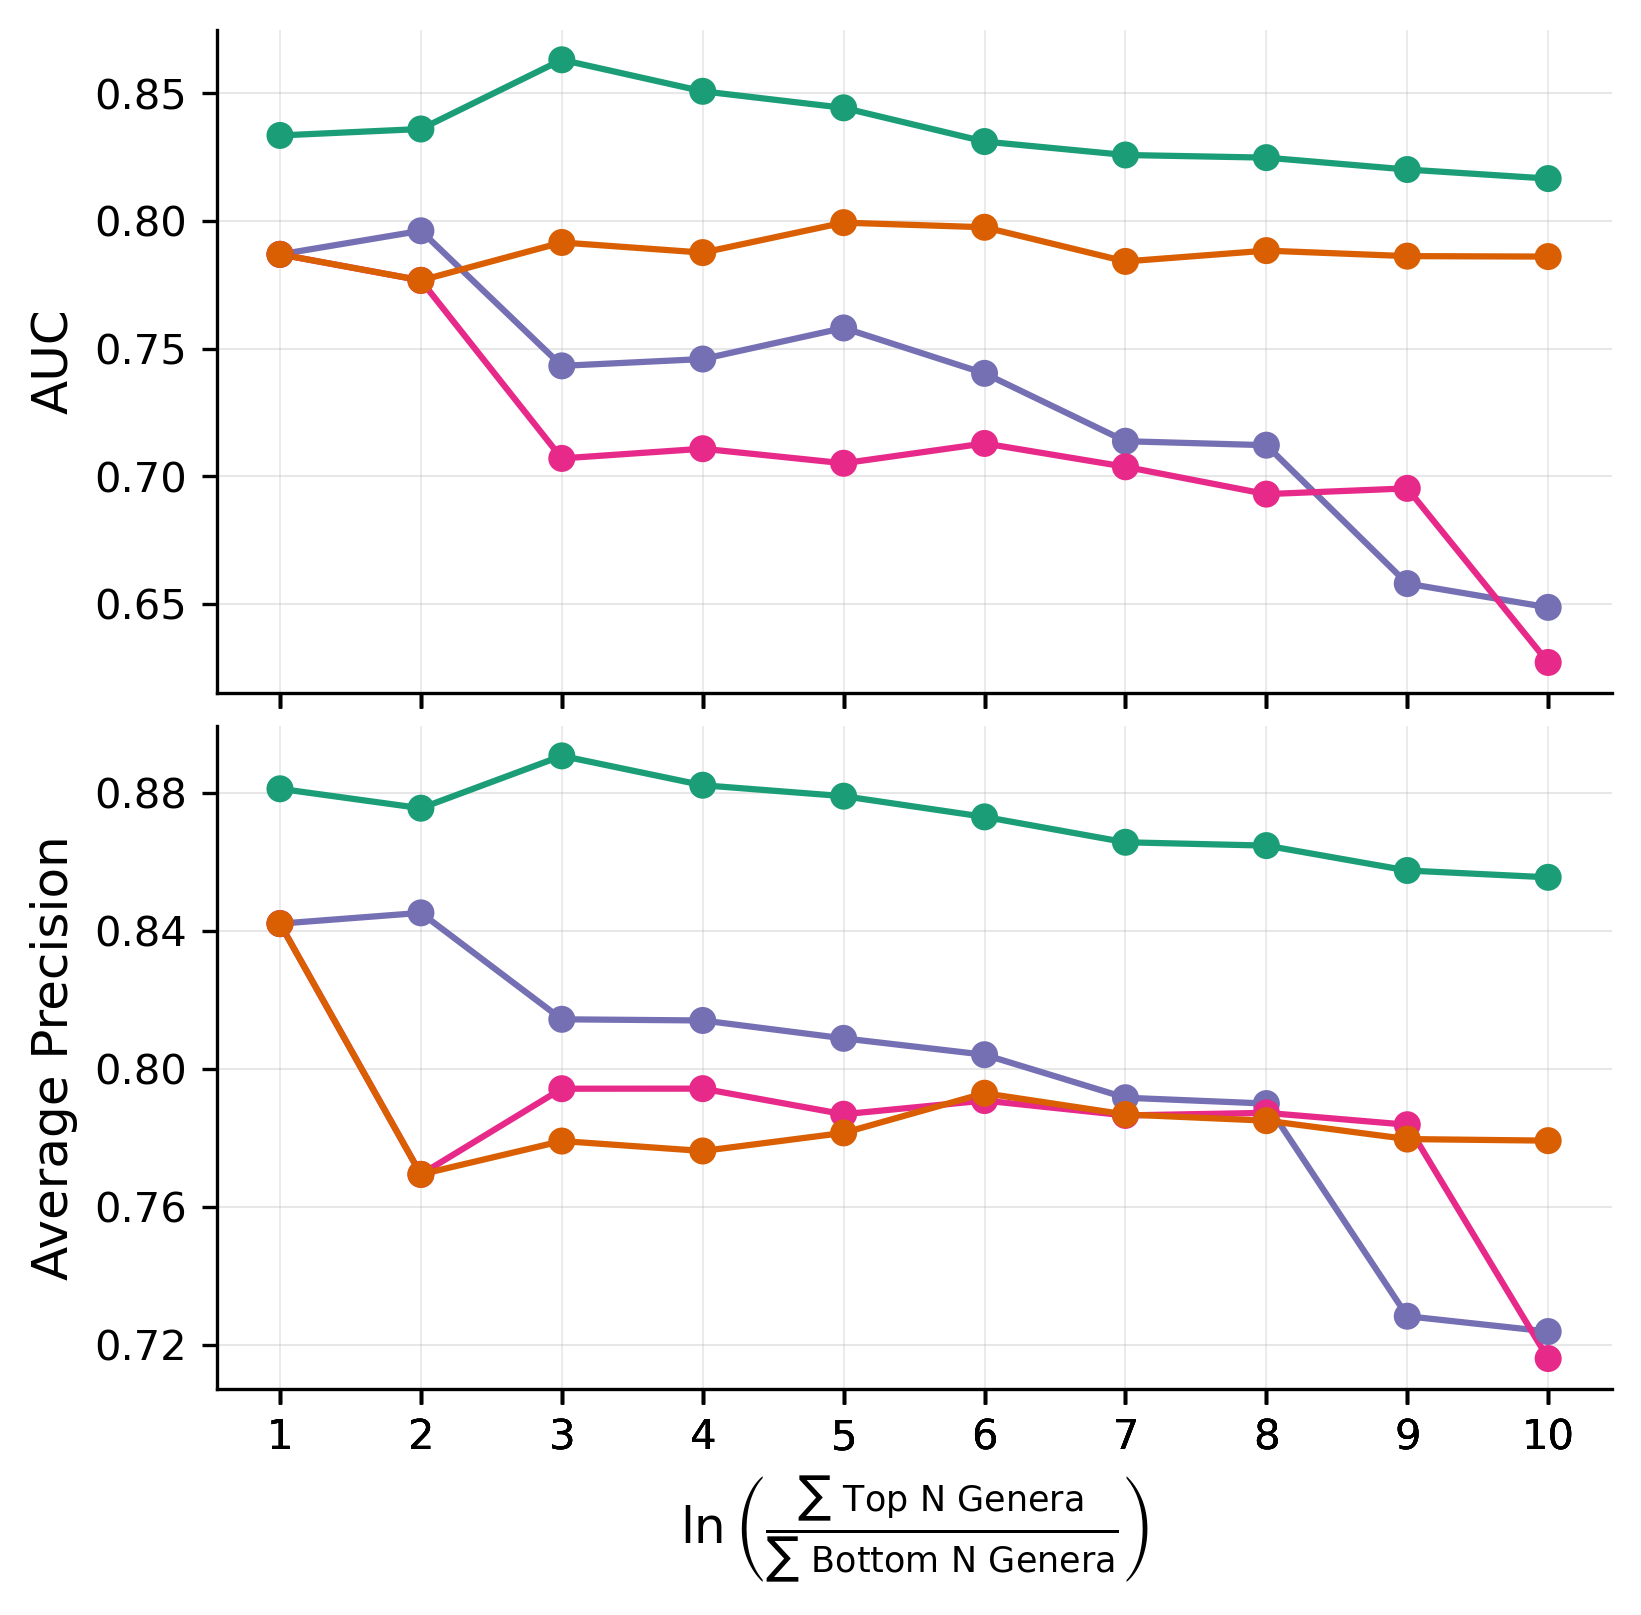

In [45]:
fig, axs = plt.subplots(2, 1, figsize=(6, 6), sharex=True)
plt.subplots_adjust(hspace=0.05)

for ax, val_df, s in zip(axs, [auc_df, ap_df], ["AUC", "Average Precision"]):
    args = {
        "data": val_df,
        "x": "index",
        "y": s,
        "hue": "Tool",
        "palette": tool_palette,
        "legend": False,
        "ax": ax
    }
    sns.scatterplot(**args, edgecolor=None, zorder=2)
    sns.lineplot(**args, zorder=1)
    
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()
    
    x_range = x_max - x_min
    y_range = y_max - y_min

    ax.grid(axis="x", alpha=0.3, linewidth=x_range*0.01)
    ax.grid(axis="y", alpha=0.3, linewidth=0.5, which="both")
    ax.yaxis.set_major_locator(ticker.MaxNLocator(6))
    ax.set_xticks(val_df["index"])

ax.set_xlabel(r"$\ln\left(\frac{\sum\ \mathrm{Top\ N\ Genera}}{\sum\ \mathrm{Bottom\ N\ Genera}}\right)$")

plt.show()

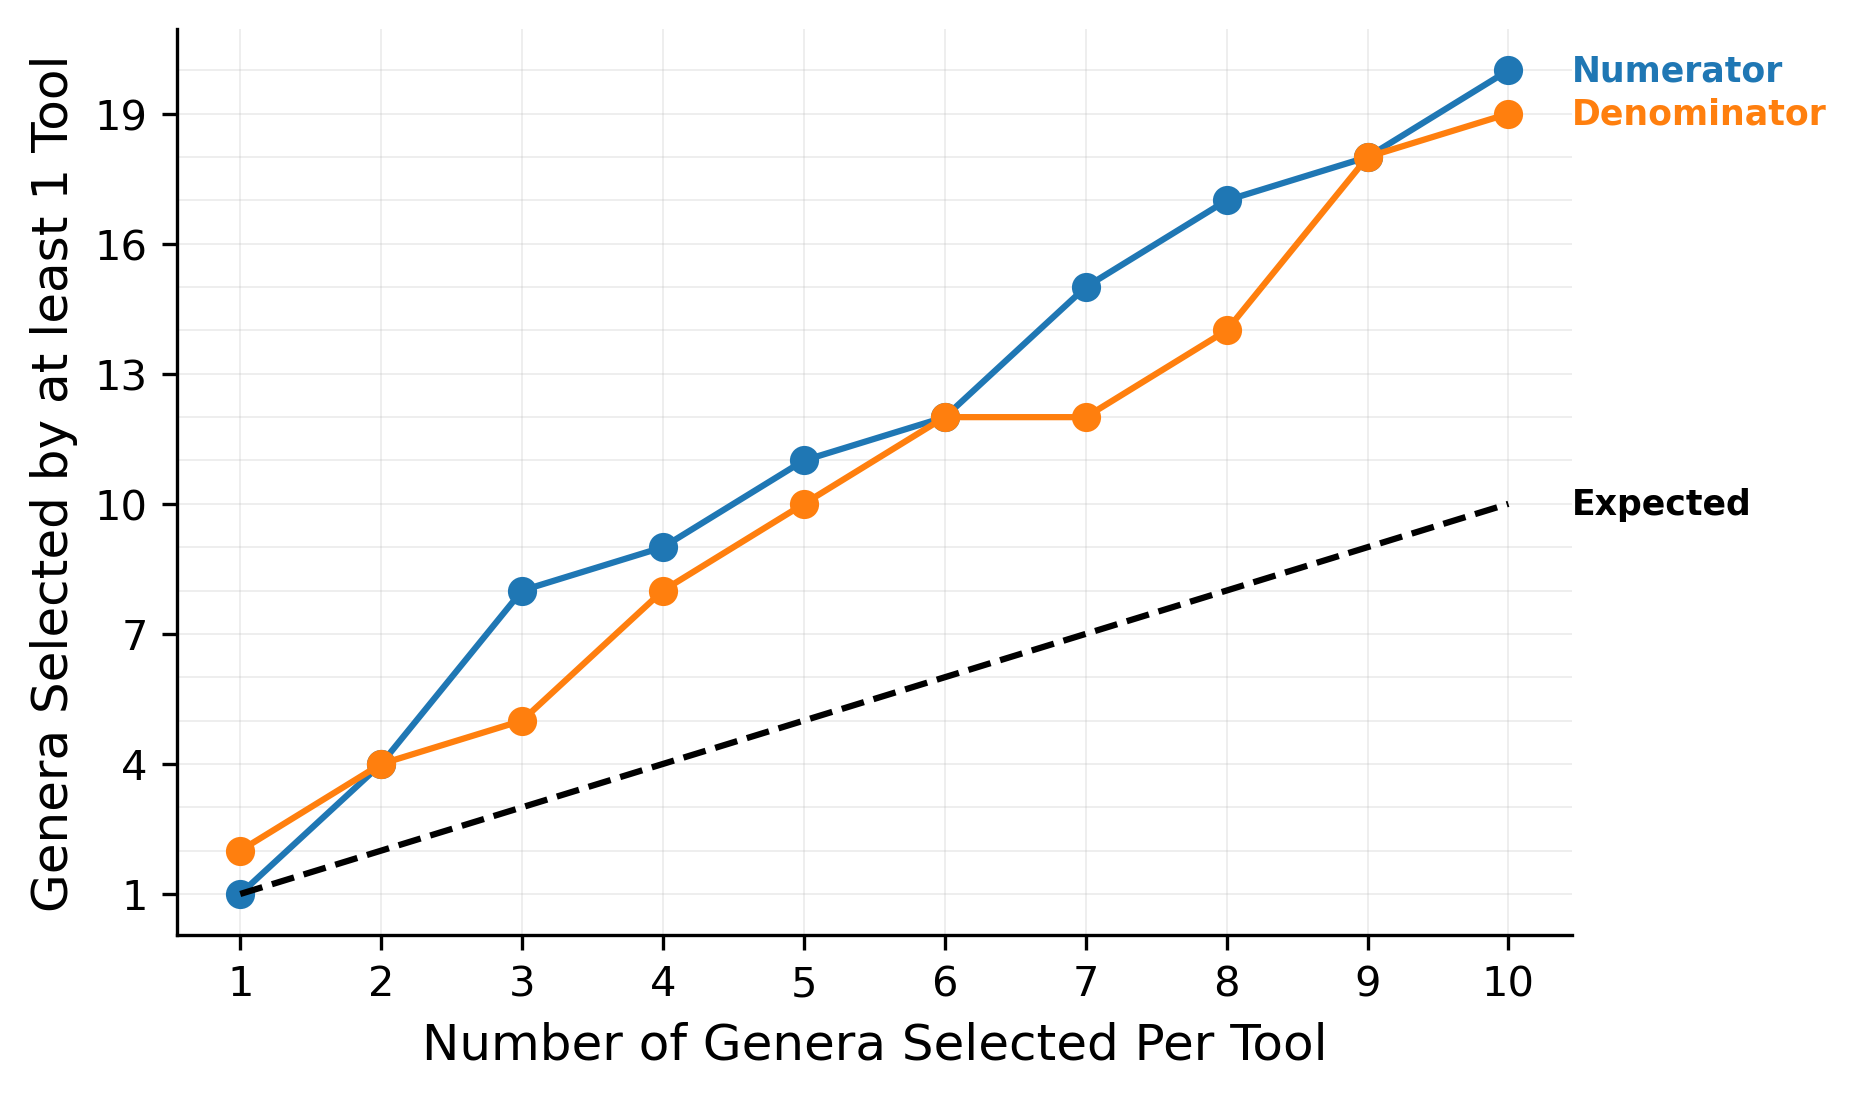

In [46]:
fig, ax = plt.subplots(1, 1)

idx = list(shared_genera_dict.keys())
top_lengths = []
bot_lengths = []

colors = sns.color_palette("tab10", 2).as_hex()

for i, d in shared_genera_dict.items():
    top_len = len(d["top"])
    bot_len = len(d["bottom"])
    
    top_lengths.append(top_len)
    bot_lengths.append(bot_len)

for loc, lengths, c in zip(["Numerator", "Denominator"], [top_lengths, bot_lengths], colors):
    ax.plot(
        idx,
        lengths,
        "o",
        color=c,
        ls="-",
        label=f"{loc} Genera"
    )
    
    ax.text(
        x=x_max,
        y=lengths[-1],
        s=loc,
        fontsize="small",
        ha="left",
        va="center",
        c=c,
        weight="bold"
    )

ax.plot(
    idx,
    idx,
    color="black",
    ls="--"
)
ax.text(
    x=x_max,
    y=idx[-1],
    s="Expected",
    fontsize="small",
    ha="left",
    va="center",
    c="k",
    weight="bold"
)

ax.set_xlabel("Number of Genera Selected Per Tool")
ax.set_ylabel("Genera Selected by at least 1 Tool")
ax.set_xticks(idx)
ax.tick_params("y", which="minor", width=0)
ax.grid(which="both")

ax.set_yticks(np.arange(1, 22, 3))
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(3))

plt.savefig("../figures/")
plt.show()

In [47]:
lr_df_all_tools = pd.concat(lr_df_list).reset_index()
lr_df_all_tools["study_id"] = lr_df_all_tools["study_id"].str.replace("_", " ").map(lambda x: x.title())
# Remove study 10422 as it has only HFD samples
lr_df_all_tools = lr_df_all_tools.query("study_id != 'Study 10422'")
lr_df_all_tools.head()

,index,log_ratio,study_id,diet,Tool,N
20,S107.CM01,5.342334,Study 107,HFD,ALDEx2,1
21,S107.CM02,6.261492,Study 107,HFD,ALDEx2,1
22,S107.CM03,5.176150,Study 107,HFD,ALDEx2,1
23,S107.CM04,5.602119,Study 107,HFD,ALDEx2,1
24,S107.CM06,4.997212,Study 107,HFD,ALDEx2,1


ALDEx2 (2/6 Correct Direction)
ANCOM-BC (2/6 Correct Direction)
DESeq2 (5/6 Correct Direction)
BIRDMAn (6/6 Correct Direction)


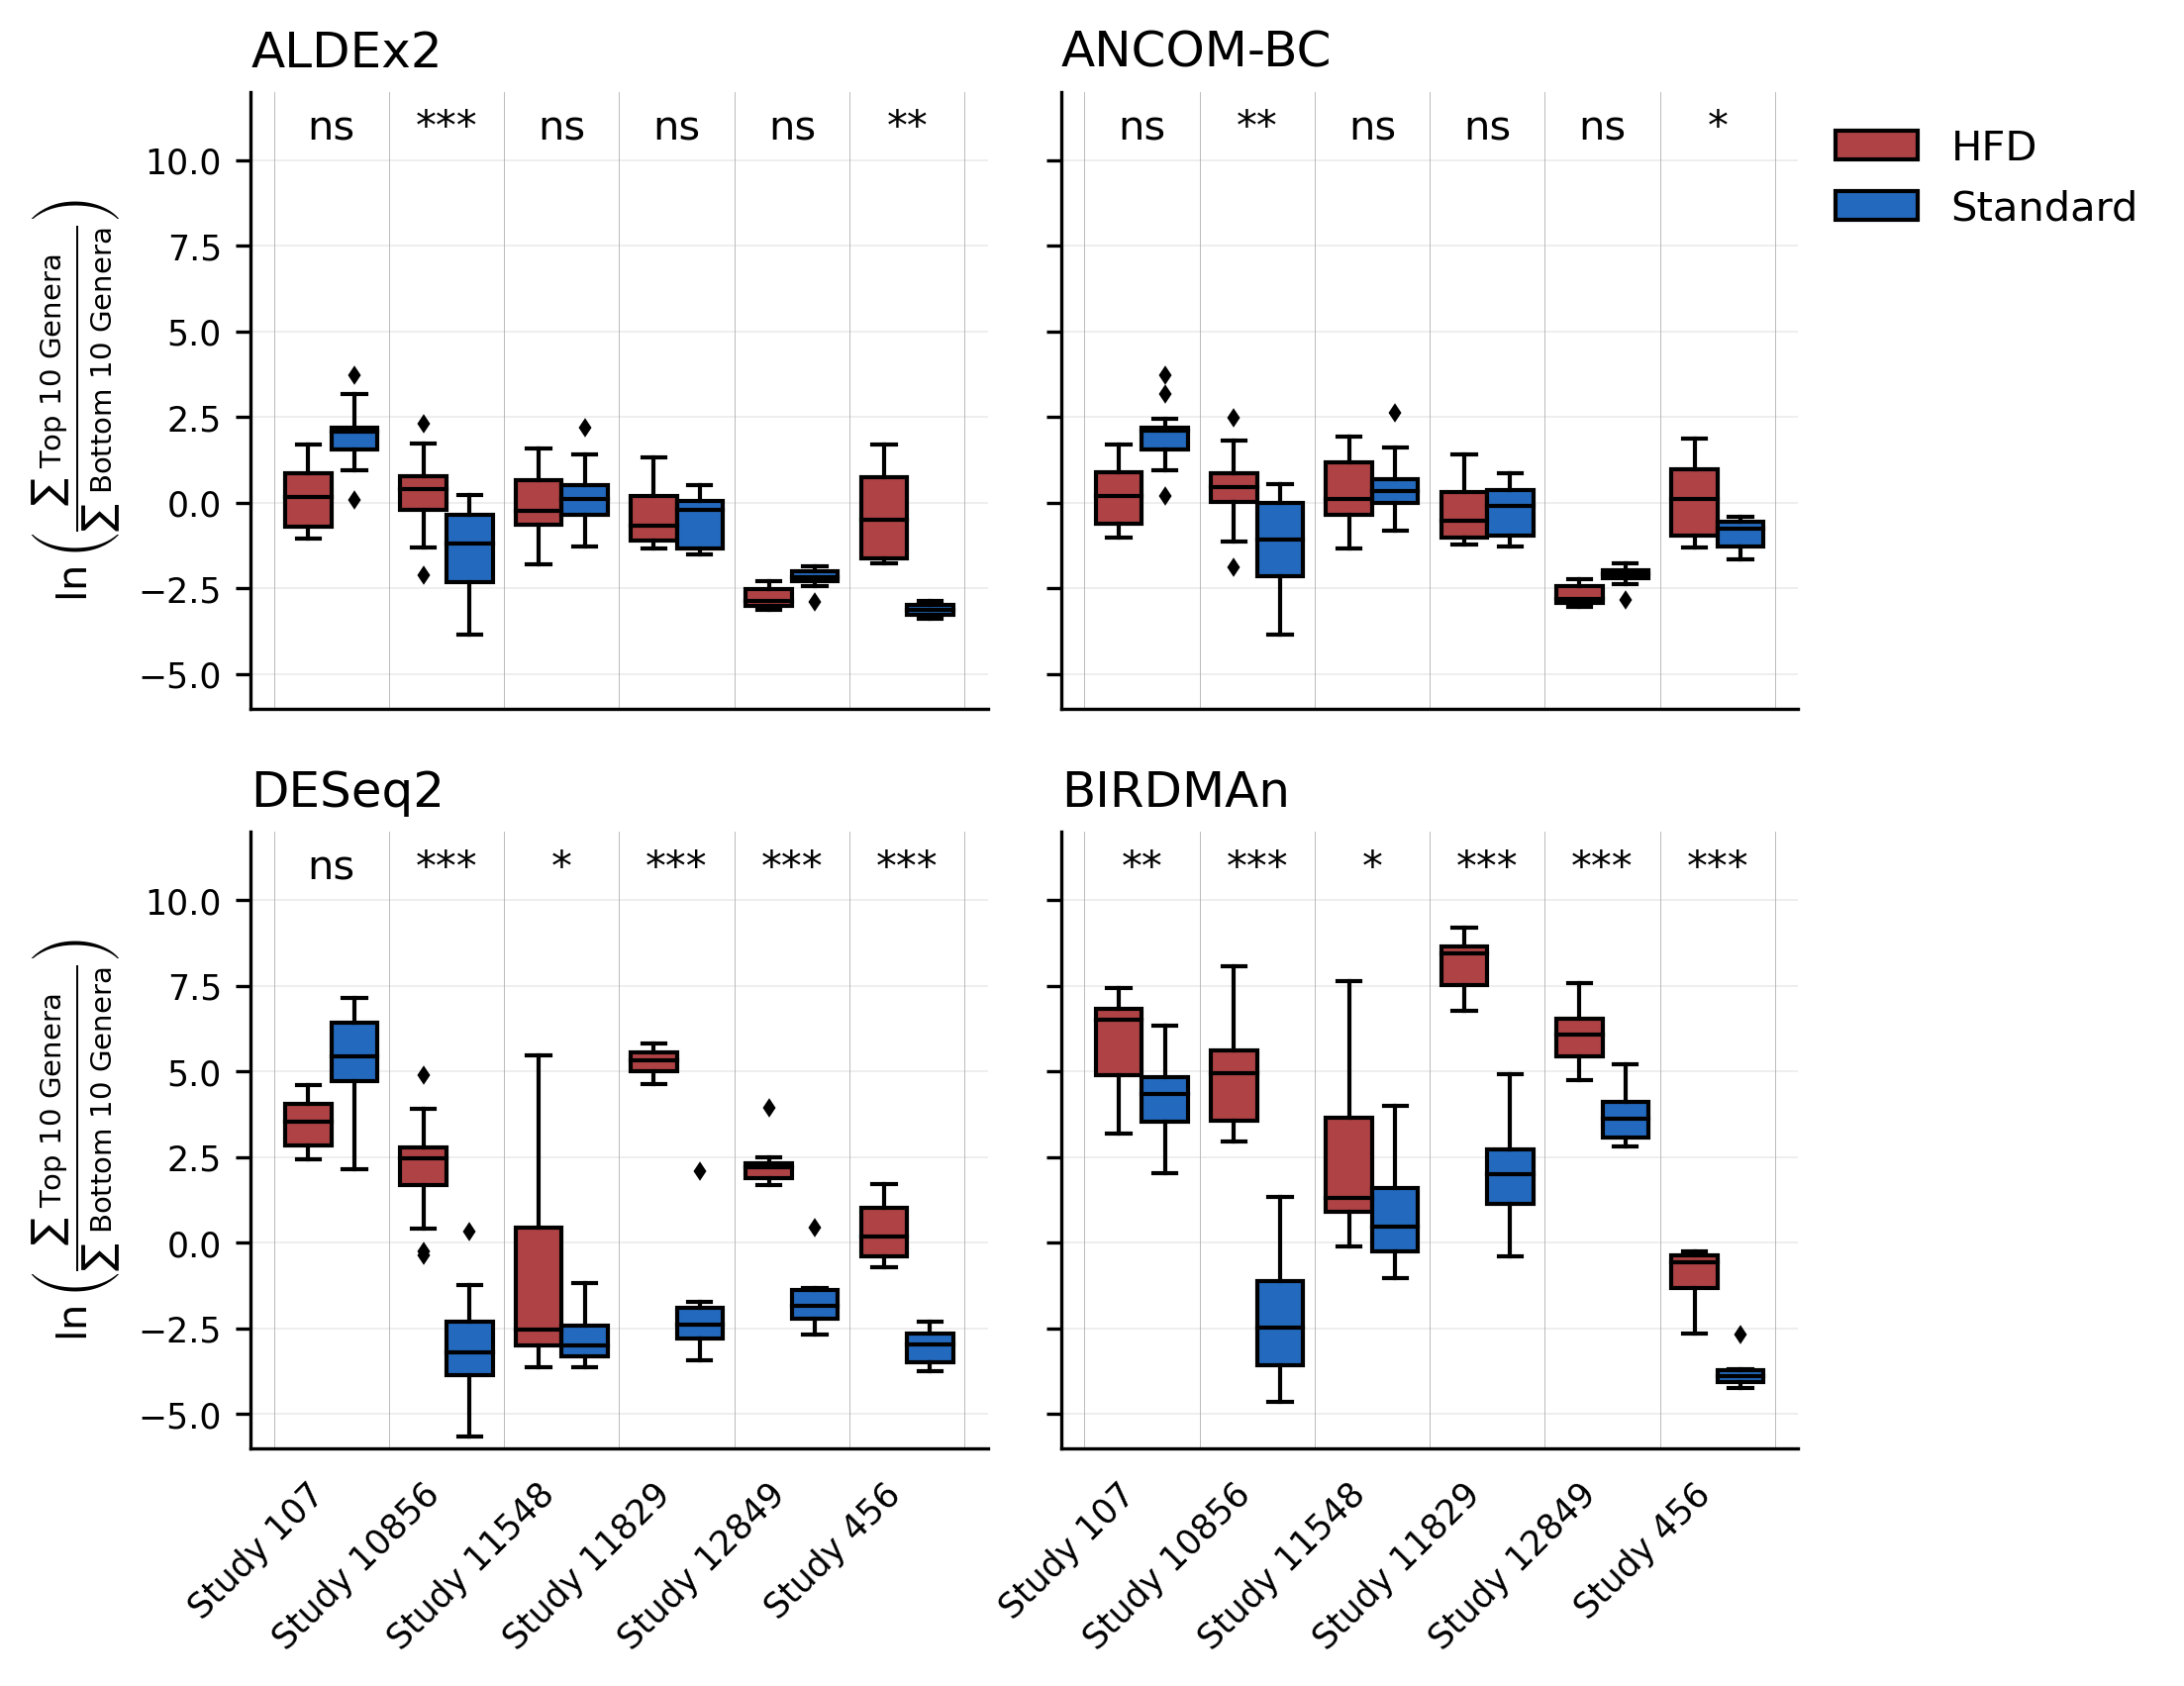

In [48]:
diet_pal = {
    "HFD": bar_colors[-1],
    "Standard": bar_colors[0]
}

_df = lr_df_all_tools.query("N == '10' and study_id != 'Study 10422'")
g = sns.FacetGrid(
    _df,
    col="Tool",
    col_wrap=2,
    height=3
)

wrong_dir_count_dict = dict()
num_studies = len(_df["study_id"].unique())
def study_plot(study, log_ratios, diet, Tool, **kwargs):
    tool = Tool.unique().item()
    ax = plt.gca()
    
    study_df = pd.concat([study, log_ratios, diet], axis=1)
    study_order = []
    for i, (_study, _study_df) in enumerate(study_df.groupby("study_id")):
        study_order.append(_study)
        positions = [i - 0.2, i + 0.2]
        
        diet_vals = []
        for pos, diet_type in zip(positions, ["HFD", "Standard"]):
            c = diet_pal[diet_type]
            vals = _study_df[_study_df["diet"] == diet_type]["log_ratio"]
            ax.boxplot(
                vals,
                positions=[pos],
                widths=0.4,
                patch_artist=True,
                boxprops={"facecolor": c, "linewidth": 1, "edgecolor": "black"},
                medianprops={"color": "black", "linewidth": 1},
                flierprops={"marker": "d", "markerfacecolor": "black", "markersize": 2}
            )
            diet_vals.append(vals)
        
        t, p = ss.ttest_ind(*diet_vals, alternative="greater")
        
        sig_text = ""
        if p < 0.05:
            sig_text += "*"
            if p < 0.005:
                sig_text += "*"
                if p < 0.0005:
                    sig_text += "*"
        else:
            sig_text = "ns"
        
        ax.text(
            x=i,
            y=11.5,
            s=sig_text,
            ha="center",
            va="top"
        )

    ax.set_ylim([-6, 12])
    ax.set_xticks(np.arange(num_studies))
    ax.set_xticklabels(study_order, rotation=45, ha="right")
    ax.xaxis.set_minor_locator(mticker.AutoMinorLocator(2))
    ax.grid(which="minor", axis="x", linewidth=0.2)
    ax.grid(axis="y", which="major")
    ax.tick_params("x", which="both", width=0)
    ax.tick_params("both", labelsize="small")
    
    correct_dir = study_df.groupby("study_id").apply(get_counter).sum()
    print(f"{tool} ({correct_dir}/6 Correct Direction)")
    
def get_counter(df):
    hfd_val = np.median(df[df["diet"] == "HFD"]["log_ratio"])
    sd_val = np.median(df[df["diet"] == "Standard"]["log_ratio"])
    return hfd_val > sd_val

g.map(study_plot, "study_id", "log_ratio", "diet", "Tool")
(
    g
    .set_axis_labels(
        "",
        r"$\ln\left(\frac{\sum\ \mathrm{Top\ 10\ Genera}}{\sum\ \mathrm{Bottom\ 10\ Genera}}\right)$",
        fontsize="medium"
    )
    .set_titles("{col_name}")
)
g.figure.subplots_adjust(wspace=0.1, hspace=0.2)

hfd_patch = Patch(facecolor=diet_pal["HFD"], label="HFD", edgecolor="black")
sd_patch = Patch(facecolor=diet_pal["Standard"], label="Standard", edgecolor="black")
handles = [hfd_patch, sd_patch]

g.axes[1].legend(
    handles=handles,
    loc="upper left",
    bbox_to_anchor=[1, 1],
    frameon=False,
    fontsize="medium"
)

plt.savefig("../figures/obesity/lr_by_study_mouse.pdf")
plt.show()

In [49]:
gg97_tax = pd.read_table("../data/relman_abx/ref/97_otu_taxonomy.txt", sep="\t", index_col=0, header=None)
gg97_tax.columns = ["Taxon"]
gg97_tax = gg97_tax["Taxon"].str.split("; ", expand=True)
gg97_tax.columns = list("kpcofgs")
gg97_tax.index.name = "OTU_ID"
gg97_tax.index = [f"F{x}" for x in gg97_tax.index]
gg97_tax = gg97_tax[gg97_tax["g"].isin(tool_df.index)]
print(gg97_tax.shape)
gg97_tax.head()

(9421, 7)


,k,p,c,o,f,g,s
F537085,k__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Enterobacteriales,f__Enterobacteriaceae,g__Klebsiella,s__
F4449524,k__Bacteria,p__Bacteroidetes,c__Bacteroidia,o__Bacteroidales,f__Prevotellaceae,g__Prevotella,s__
F180905,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__Lachnospiraceae,g__Blautia,s__
F3002161,k__Bacteria,p__Firmicutes,c__Erysipelotrichi,o__Erysipelotrichales,f__Erysipelotrichaceae,g__[Eubacterium],s__dolichum
F1991307,k__Bacteria,p__Firmicutes,c__Bacilli,o__Lactobacillales,f__Lactobacillaceae,g__Lactobacillus,s__


In [50]:
genus_tax_dict = gg97_tax.drop(columns=["s"]).groupby(["g"]).first().to_dict(orient="index")

# Human Meta-Analysis

In [51]:
tbl_human = biom.load_table("../data/obesity/processed/human/processed_tbl.genus.biom")
tbl_human_df = tbl_human.to_dataframe(dense=True)
tbl_human

32 x 282 <class 'biom.table.Table'> with 6105 nonzero entries (67% dense)

In [52]:
md_human = pd.read_table("../data/obesity/processed/human/processed_md.tsv", sep="\t", index_col=0)
md_human.head()

,obese,study_id
S12879.301cntrl,Lean,12879
S12879.303cntrl,Lean,12879
S12879.CT25,Lean,12879
S12879.CT27,Lean,12879
S12879.CT53,Lean,12879


In [53]:
ord_res_human, dm_human = rpca(tbl_human)
samp_axes_human = ord_res_human.samples.join(md_human)

/home/grahman/miniconda3/envs/birdman-analyses-final/lib/python3.8/site-packages/gemelli/preprocessing.py:418: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(mat))


In [54]:
permanova(dm_human, md_human, "obese")

method name               PERMANOVA
test statistic name        pseudo-F
sample size                     282
number of groups                  2
test statistic              14.3306
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object

In [55]:
permanova(dm_human, md_human, "study_id")

method name               PERMANOVA
test statistic name        pseudo-F
sample size                     282
number of groups                  2
test statistic              169.503
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object

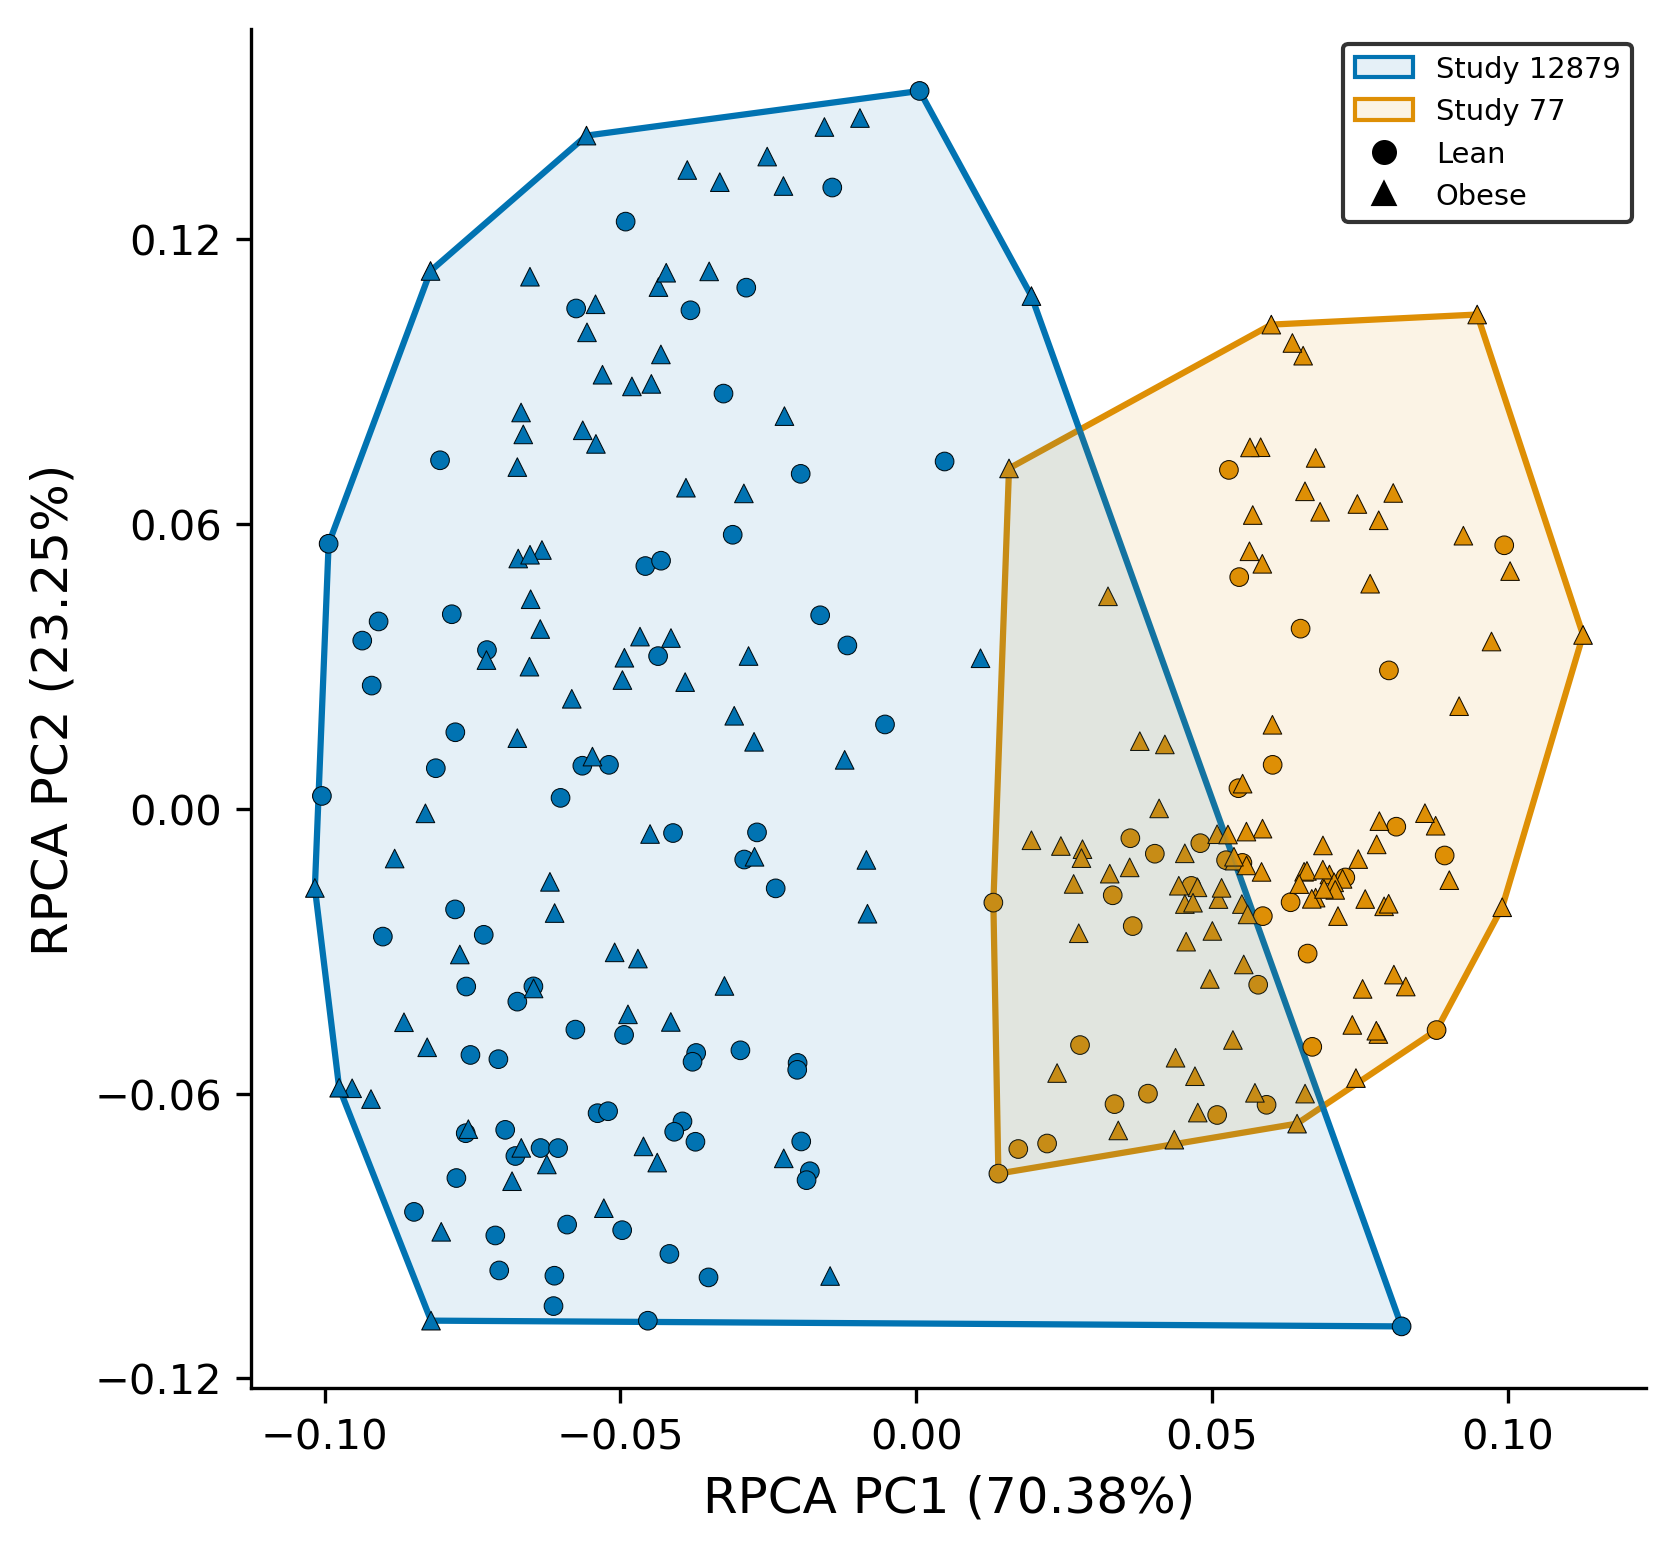

In [56]:
studies = md_human["study_id"].unique()
pal = dict(zip(
    studies,
    sns.color_palette("colorblind", len(studies)).as_hex()
))
pal2 = dict(zip(
    studies,
    sns.color_palette("colorblind", len(studies))
))

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    
for bs, df in samp_axes_human.groupby("study_id"):
    color = pal.get(bs)
    df["color"] = color
        
    for obese, obese_df in df.groupby("obese"):
        if obese == "Obese":
            marker = "^"
        else:
            marker = "o"
            
        ax.scatter(
            x=obese_df["PC1"],
            y=obese_df["PC2"],
            s=20,
            marker=marker,
            c=obese_df["color"],
            edgecolor="black",
            linewidth=0.25,
        )
    
    points = df[["PC1", "PC2"]].values
    hull = scipy.spatial.ConvexHull(points)
    hull_plot_x = points[hull.vertices, 0]
    hull_plot_y = points[hull.vertices, 1]
    # Connect last point with first point
    hull_plot_x = np.append(hull_plot_x, points[hull.vertices[0], 0])
    hull_plot_y = np.append(hull_plot_y, points[hull.vertices[0], 1])

    ax.plot(
        hull_plot_x,
        hull_plot_y,
        c=color,
        zorder=0
    )
    ax.fill(
        points[hull.vertices, 0],
        points[hull.vertices, 1],
        c=color,
        alpha=0.1
    )

handles  = []
for study in studies:
    label = f"Study {study}"
    c = pal.get(study)
    _c = list(pal2.get(study)) + [0.1]
    study_patch = Patch(facecolor=_c, label=label, edgecolor=c)
    handles.append(study_patch)

lean_line = Line2D([0], [0], marker="o", label="Lean", color="black", lw=0, markersize=5)
obese_line = Line2D([0], [0], marker="^", label="Obese", color="black", lw=0, markersize=5)
handles.extend([lean_line, obese_line])
    
ax.legend(
    handles=handles,
    loc="upper right",
    edgecolor="black"
)

prop_1, prop_2, _ = [x * 100 for x in ord_res_human.proportion_explained]
ax.set_xlabel(f"RPCA PC1 ({prop_1:.2f}%)")
ax.set_ylabel(f"RPCA PC2 ({prop_2:.2f}%)")

ax.xaxis.set_major_locator(ticker.MaxNLocator(5))
ax.yaxis.set_major_locator(ticker.MaxNLocator(5))

plt.show()

In [57]:
inf_human = az.from_netcdf("../results/obesity/human/inf.genus.human.nc")
inf_human.posterior

<xarray.Dataset>
Dimensions:     (chain: 4, draw: 500, feature: 32, study: 2, covariate: 2)
Coordinates:
  * chain       (chain) int64 0 1 2 3
  * draw        (draw) int64 0 1 2 3 4 5 6 7 ... 492 493 494 495 496 497 498 499
  * study       (study) int64 77 12879
  * covariate   (covariate) object 'Intercept' "C(obese, Treatment('Lean'))[T...
  * feature     (feature) object 'g__Coprococcus' ... 'g__Clostridium'
Data variables:
    base_phi    (feature, chain, draw) float64 ...
    study_disp  (feature, chain, draw, study) float64 ...
    study_re    (feature, chain, draw, study) float64 ...
    beta_var    (feature, chain, draw, covariate) float64 ...
Attributes:
    created_at:                 2022-08-16T16:58:07.981799
    arviz_version:              0.12.1
    inference_library:          cmdstanpy
    inference_library_version:  1.0.4

In [58]:
az.rhat(inf_human).max()

<xarray.Dataset>
Dimensions:     ()
Data variables:
    base_phi    float64 1.008
    study_disp  float64 1.01
    study_re    float64 1.012
    beta_var    float64 1.012

In [59]:
az.loo(inf_human, pointwise=True)

/home/grahman/miniconda3/envs/birdman-analyses-final/lib/python3.8/site-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 2000 posterior samples and 9024 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -35143.51   295.02
p_loo      189.74        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     9001   99.7%
 (0.5, 0.7]   (ok)         15    0.2%
   (0.7, 1]   (bad)         4    0.0%
   (1, Inf)   (very bad)    4    0.0%

In [60]:
obese_str = "C(obese, Treatment('Lean'))[T.Obese]"

In [61]:
beta_var_human = (
    inf_human.posterior["beta_var"].sel({"covariate": obese_str}) - 
    inf_human.posterior["beta_var"].sel({"covariate": obese_str}).mean(["feature", "chain", "draw"])
).stack(sample=["chain", "draw"])
beta_var_human

<xarray.DataArray 'beta_var' (feature: 32, sample: 2000)>
array([[-0.2884759, -0.2927659, -0.3474729, ...,  0.0084951, -0.5561189,
        -0.4939549],
       [ 1.1402381,  1.3105201,  1.3809911, ...,  0.8253361,  0.5998431,
         1.5036711],
       [-0.3174269, -0.5907079, -0.1543139, ...,  0.2392593, -0.2051269,
        -0.2940129],
       ...,
       [ 0.2740141,  0.3690309,  0.2270321, ...,  0.3574039,  0.2969774,
        -0.2885429],
       [ 0.3040658,  0.6838641,  0.7772991, ...,  0.7639021,  0.4055448,
         0.5557221],
       [-0.4860999, -0.6742289, -0.3927519, ..., -0.8693489, -0.9273889,
        -0.7372789]])
Coordinates:
    covariate  <U36 "C(obese, Treatment('Lean'))[T.Obese]"
  * feature    (feature) object 'g__Coprococcus' ... 'g__Clostridium'
  * sample     (sample) MultiIndex
  - chain      (sample) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3
  - draw       (sample) int64 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499

In [62]:
human_genera = inf_human.posterior.coords["feature"].values

In [63]:
inf_mouse = az.from_netcdf("../results/obesity/inf.genus2.nc")
diet_str = "C(diet, Treatment('Standard'))[T.HFD]"
beta_var_mouse = inf_mouse.posterior["beta_var"].sel({"covariate": diet_str, "feature": human_genera})
beta_var_mouse = (
    beta_var_mouse - 
    beta_var_mouse.mean(["feature", "chain", "draw"])
).stack(sample=["chain", "draw"])
beta_var_mouse

<xarray.DataArray 'beta_var' (feature: 32, sample: 2000)>
array([[ 0.33556926,  0.52585316,  0.35615656, ...,  0.35919576,
         0.36420506,  0.37780146],
       [-0.78866084,  0.34255276, -0.26925284, ..., -0.23715184,
         0.05692216, -1.37739084],
       [-0.93653084,  1.40266916,  0.82556616, ...,  1.57310916,
         2.26237916,  1.10360716],
       ...,
       [-2.65666084, -0.32345884,  0.07565716, ..., -1.29357084,
        -0.93730084, -0.74212084],
       [ 1.41051916,  1.89343916,  1.89182916, ...,  1.95109916,
         1.95435916,  2.25901916],
       [ 0.32378696, -0.35337784,  0.24158816, ..., -0.16006584,
        -0.18808484, -0.24234584]])
Coordinates:
    covariate  <U37 "C(diet, Treatment('Standard'))[T.HFD]"
  * feature    (feature) object 'g__Coprococcus' ... 'g__Clostridium'
  * sample     (sample) MultiIndex
  - chain      (sample) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3
  - draw       (sample) int64 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499

In [64]:
human_means = beta_var_human.mean("sample").to_pandas().sort_values()
human_stds = beta_var_human.std("sample").to_pandas()

human_values = pd.concat([human_means, human_stds], axis=1)
human_values.columns = ["obese_mean", "obese_std"]
human_values.head()

,obese_mean,obese_std
g__Dehalobacterium,-1.401308,0.342038
g__Coprobacillus,-1.328622,0.499731
g__Acinetobacter,-1.219633,0.526629
g__Clostridium,-0.862905,0.182735
g__Adlercreutzia,-0.729408,0.287146


In [65]:
human_genus_counts = pd.read_table("../results/obesity/human/genus_counts.human.tsv", sep="\t", index_col=0)
human_genus_counts.head()

,count
g,
g__Coprococcus,58
g__Eggerthella,1
g__Alistipes,2
g__Dehalobacterium,5
g__Faecalibacterium,29


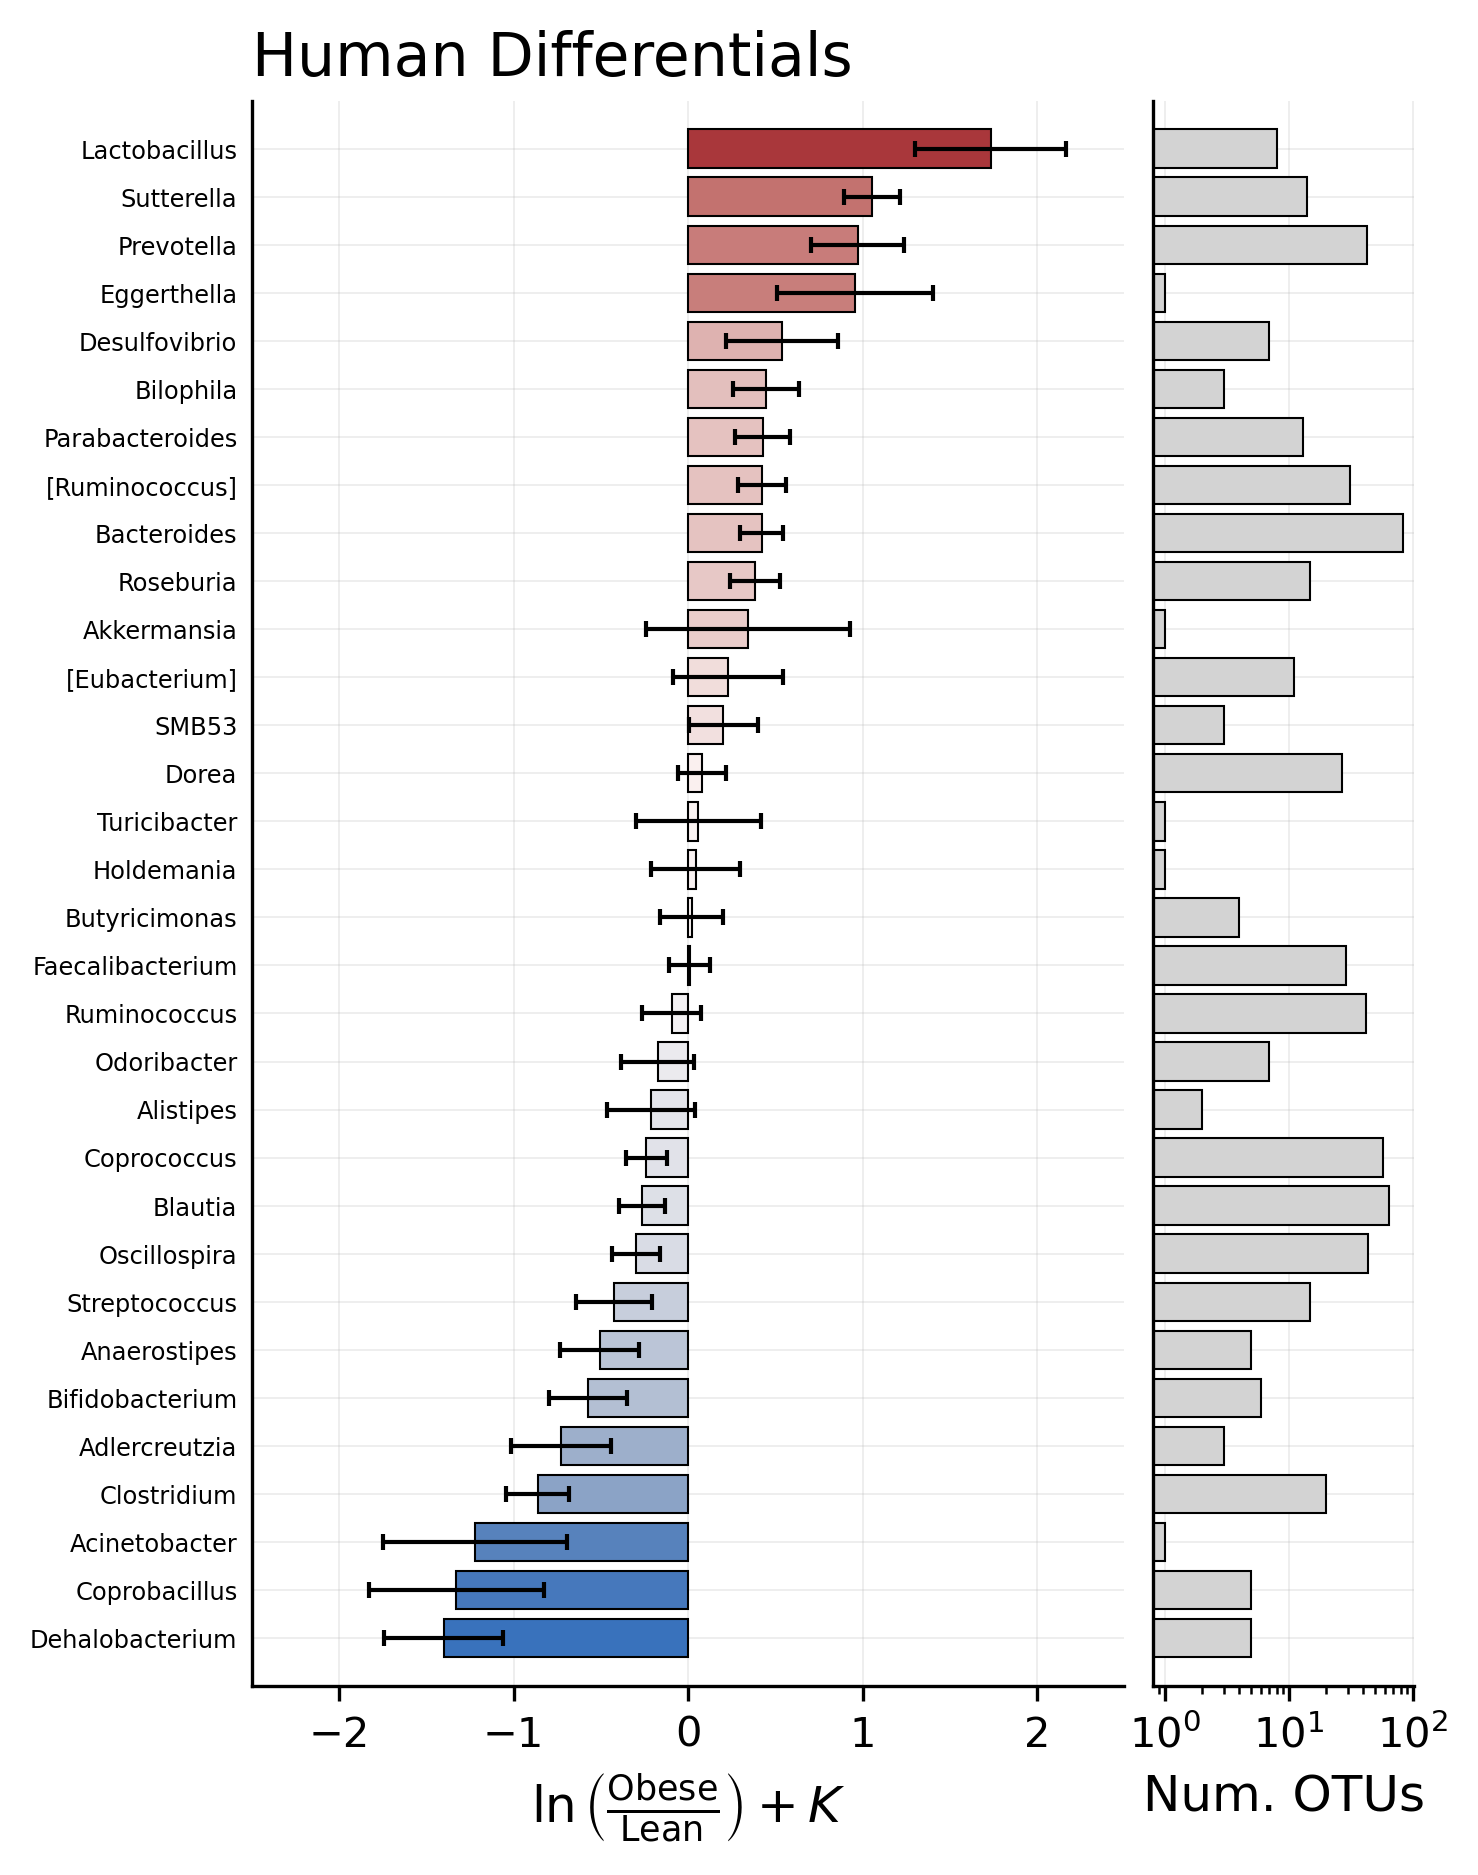

In [66]:
fig = plt.figure(figsize=(5, 7))
gs = GridSpec(ncols=2, nrows=1, width_ratios=[1, 0.3], wspace=0.05)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

_counts = human_genus_counts.loc[human_values.index]["count"]

x = np.arange(human_values.shape[0])
cmap = sns.color_palette("vlag", as_cmap=True)
norm = Normalize(-1.5, 1.5)
bar_colors = cmap(norm(human_values["obese_mean"]))

ax1.barh(
    x,
    human_values["obese_mean"],
    xerr=human_values["obese_std"],
    color=bar_colors,
    edgecolor="black",
    lw=0.5,
    capsize=2,
    error_kw={"lw": 1, "capthick": 1}
)
ax1.set_xlim([-2.5, 2.5])

ax1.yaxis.set_major_locator(mticker.FixedLocator(x))
ax1.set_yticklabels(
    human_means.index.str.replace("g__", ""),
    fontsize="xx-small"
)
ax1.tick_params("y", width=0, pad=0)
ax1.grid(linewidth=0.1)
ax1.set_ylim([-1, max(x)+1])
ax1.set_xlabel(r"$\ln\left(\frac{\mathrm{Obese}}{\mathrm{Lean}}\right) + K$")

ax2.barh(
    x,
    _counts,
    color="lightgray",
    edgecolor="black",
    lw=0.5
)
ax2.yaxis.set_major_locator(mticker.FixedLocator(x))
ax2.set_yticklabels([])
ax2.tick_params("y", width=0)
ax2.set_xscale("log")
ax2.set_ylim(ax1.get_ylim())
ax2.grid(lw=0.1)
ax2.set_xlabel("Num. OTUs")
ax1.set_title("Human Differentials")

plt.savefig("../figures/obesity/human_differentials.pdf")
plt.show()

In [67]:
num_draws = len(beta_var_human.coords["sample"])

In [68]:
mouse_rank_means = beta_var_mouse.to_pandas().droplevel(0, axis=1).rank(ascending=False).mean(axis=1).sort_values()
human_rank_means = beta_var_human.to_pandas().droplevel(0, axis=1).rank(ascending=False).mean(axis=1).sort_values()

mean_rank_df = pd.concat([mouse_rank_means, human_rank_means], axis=1)
mean_rank_df.columns = ["mouse_rank_mean", "human_rank_mean"]
mean_rank_df["rank_diff"] = mean_rank_df["mouse_rank_mean"] - mean_rank_df["human_rank_mean"]
mean_rank_df["abs_rank_diff"] = mean_rank_df["rank_diff"].abs()
mean_rank_df = mean_rank_df.sort_values(by="rank_diff")
mean_rank_df.head()

,mouse_rank_mean,human_rank_mean,rank_diff,abs_rank_diff
g__Bifidobacterium,2.1305,26.0840,-23.9535,23.9535
g__Adlercreutzia,12.6730,27.3880,-14.7150,14.7150
g__Dehalobacterium,17.6145,30.9680,-13.3535,13.3535
g__Acinetobacter,16.8720,29.7080,-12.8360,12.8360
g__Oscillospira,10.3485,22.5145,-12.1660,12.1660


In [69]:
mean_rank_df.sort_values(by="abs_rank_diff", ascending=False)

,mouse_rank_mean,human_rank_mean,rank_diff,abs_rank_diff
g__Prevotella,31.39250,3.6105,27.78200,27.78200
g__Sutterella,27.40000,2.9570,24.44300,24.44300
g__Bifidobacterium,2.13050,26.0840,-23.95350,23.95350
g__Lactobacillus,18.29850,1.2795,17.01900,17.01900
g__Eggerthella,21.17450,4.4070,16.76750,16.76750
g__Adlercreutzia,12.67300,27.3880,-14.71500,14.71500
g__Dehalobacterium,17.61450,30.9680,-13.35350,13.35350
g__Acinetobacter,16.87200,29.7080,-12.83600,12.83600
g__Oscillospira,10.34850,22.5145,-12.16600,12.16600
g__SMB53,3.31300,12.8040,-9.49100,9.49100


In [70]:
deseq2_human_res = (
    pd.read_table("../results/obesity/human/deseq2_results.tsv", sep="\t", index_col=0)
    [["log2FoldChange", "padj"]]
    .rename(columns={"log2FoldChange": "deseq2_beta", "padj": "deseq2_qval"})
    .sort_values(by="deseq2_beta")
)
deseq2_human_res.head()

,deseq2_beta,deseq2_qval
g__Bifidobacterium,-1.523477,0.000041
g__Dehalobacterium,-1.501197,0.001716
g__Clostridium,-1.195776,0.000008
g__Oscillospira,-1.148998,0.000004
g__Anaerostipes,-0.922505,0.009706


In [71]:
ancombc_human_res = (
    pd.read_table("../results/obesity/human/ancombc_results.tsv", sep="\t", index_col=0)
    [["beta", "q_val"]]
    .rename(columns={"beta": "ancombc_beta", "q_val": "ancombc_qval"})
    .sort_values(by="ancombc_beta")
)
ancombc_human_res.head()

,ancombc_beta,ancombc_qval
g__Oscillospira,-0.778512,0.000117
g__Bifidobacterium,-0.753886,0.007755
g__Clostridium,-0.665169,0.000821
g__Ruminococcus,-0.631752,0.000510
g__Faecalibacterium,-0.587163,0.004616


In [72]:
aldex2_human_res = (
    pd.read_table("../results/obesity/human/aldex2_results.tsv", sep="\t", index_col=0)
    [["model.obeseObese Estimate", "model.obeseObese Pr(>|t|).BH"]]
    .rename(columns={"model.obeseObese Estimate": "aldex2_beta","model.obeseObese Pr(>|t|).BH": "aldex2_qval"})
    .sort_values(by="aldex2_beta")
)
aldex2_human_res.head()

,aldex2_beta,aldex2_qval
g__Bifidobacterium,-1.367698,0.118428
g__Anaerostipes,-1.237267,0.134397
g__Oscillospira,-1.203649,0.004000
g__Clostridium,-1.134789,0.055854
g__Alistipes,-1.087358,0.290134


In [73]:
tool_human_df = (
    aldex2_human_res.join(ancombc_human_res).join(deseq2_human_res).join(human_values[["obese_mean"]])
)
tool_human_df = tool_human_df.rename(columns={"obese_mean": "birdman_beta"})
tool_human_df.head()

,aldex2_beta,aldex2_qval,ancombc_beta,ancombc_qval,deseq2_beta,deseq2_qval,birdman_beta
g__Bifidobacterium,-1.367698,0.118428,-0.753886,0.007755,-1.523477,0.000041,-0.572403
g__Anaerostipes,-1.237267,0.134397,-0.480759,0.034929,-0.922505,0.009706,-0.506558
g__Oscillospira,-1.203649,0.004000,-0.778512,0.000117,-1.148998,0.000004,-0.299040
g__Clostridium,-1.134789,0.055854,-0.665169,0.000821,-1.195776,0.000008,-0.862905
g__Alistipes,-1.087358,0.290134,-0.344881,0.609487,-0.445546,0.255446,-0.213135


In [74]:
tool_human_df.filter(like="beta").corr("kendall")

,aldex2_beta,ancombc_beta,deseq2_beta,birdman_beta
aldex2_beta,1.000000,0.838710,0.745968,0.407258
ancombc_beta,0.838710,1.000000,0.681452,0.334677
deseq2_beta,0.745968,0.681452,1.000000,0.556452
birdman_beta,0.407258,0.334677,0.556452,1.000000


In [75]:
tool_human_ranks = tool_human_df.filter(like="beta").rank(ascending=False).sort_values(by="birdman_beta")
tool_human_ranks.head()

,aldex2_beta,ancombc_beta,deseq2_beta,birdman_beta
g__Lactobacillus,1.0,1.0,1.0,1.0
g__Sutterella,10.0,11.0,3.0,2.0
g__Prevotella,8.0,8.0,5.0,3.0
g__Eggerthella,4.0,5.0,9.0,4.0
g__Desulfovibrio,11.0,10.0,13.0,5.0


In [76]:
(tool_human_df.filter(like="qval") < 0.05).all(axis=1).sort_values()

g__Bifidobacterium     False
g__Akkermansia         False
g__Eggerthella         False
g__Coprobacillus       False
g__Acinetobacter       False
g__Holdemania          False
g__Prevotella          False
g__SMB53               False
g__Sutterella          False
g__Desulfovibrio       False
g__Bacteroides         False
g__Butyricimonas       False
g__Turicibacter        False
g__Dorea               False
g__Parabacteroides     False
g__[Ruminococcus]      False
g__Streptococcus       False
g__Coprococcus         False
g__Bilophila           False
g__Roseburia           False
g__Odoribacter         False
g__Dehalobacterium     False
g__Adlercreutzia       False
g__Ruminococcus        False
g__Alistipes           False
g__Clostridium         False
g__Anaerostipes        False
g__[Eubacterium]       False
g__Blautia              True
g__Faecalibacterium     True
g__Oscillospira         True
g__Lactobacillus        True
dtype: bool

In [77]:
_diet_values = diet_values.loc[human_values.index].sort_values(by="HFD_mean", ascending=False)

n = 11
top_human_genera = human_values.sort_values(by="obese_mean", ascending=False).head(n).index
bot_human_genera = human_values.sort_values(by="obese_mean", ascending=False).tail(n).index

top_mouse_genera = _diet_values.sort_values(by="HFD_mean", ascending=False).head(n).index
bot_mouse_genera = _diet_values.sort_values(by="HFD_mean", ascending=False).tail(n).index

top_genera_intersection = set(top_human_genera).intersection(top_mouse_genera)
bot_genera_intersection = set(bot_human_genera).intersection(bot_mouse_genera)

print(f"Top Genera Intersection:\n{top_genera_intersection}")
print(f"Bottom Genera Intersection:\n{bot_genera_intersection}")

Top Genera Intersection:
{'g__Bilophila', 'g__Roseburia', 'g__Akkermansia', 'g__Bacteroides', 'g__Parabacteroides', 'g__Desulfovibrio'}
Bottom Genera Intersection:
{'g__Clostridium', 'g__Anaerostipes', 'g__Streptococcus', 'g__Blautia', 'g__Coprobacillus'}


In [78]:
(
    tool_human_df
    .filter(like="qval")
    .apply(lambda x: x < 0.05)
    .loc[list(top_genera_intersection)]
)

,aldex2_qval,ancombc_qval,deseq2_qval
g__Bilophila,False,False,True
g__Roseburia,False,False,False
g__Akkermansia,False,True,False
g__Bacteroides,False,False,True
g__Parabacteroides,False,False,False
g__Desulfovibrio,False,False,False


In [79]:
(
    tool_human_df
    .filter(like="qval")
    .apply(lambda x: x < 0.05)
    .loc[list(bot_genera_intersection)]
)

,aldex2_qval,ancombc_qval,deseq2_qval
g__Clostridium,False,True,True
g__Anaerostipes,False,True,True
g__Streptococcus,False,False,False
g__Blautia,True,True,True
g__Coprobacillus,False,True,False


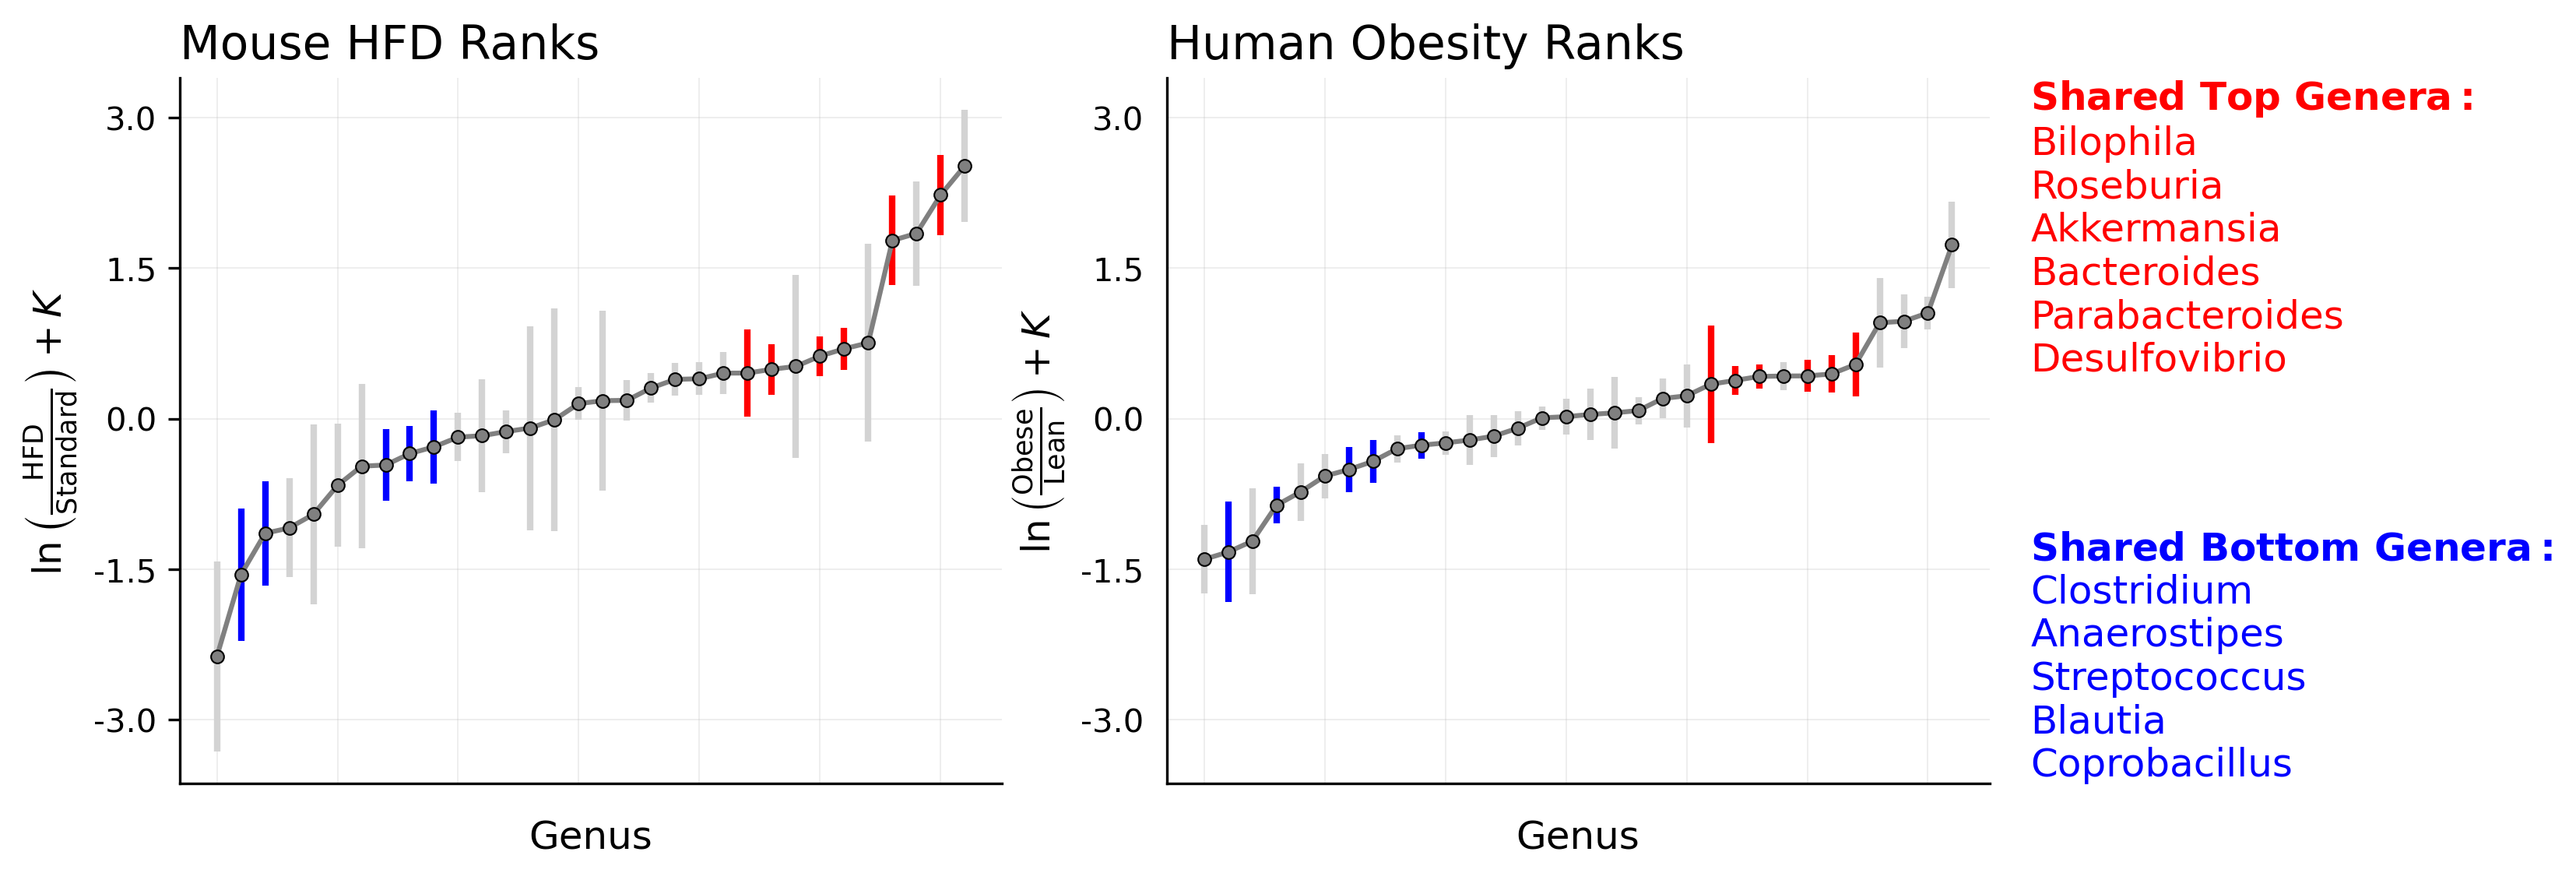

In [80]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plt.subplots_adjust(wspace=0.2)

def get_color(x):
    if x in top_genera_intersection:
        return "red"
    elif x in bot_genera_intersection:
        return "blue"
    else:
        return "lightgray"

_mouse_values = _diet_values.sort_values(by="HFD_mean")
_mouse_values["color"] = _mouse_values.index.map(get_color)
_human_values = human_values.sort_values(by="obese_mean")
_human_values["color"] = human_values.index.map(get_color)

for ax, vals in zip(axs, [_mouse_values, _human_values]):
    x = np.arange(vals.shape[0])
    ax.errorbar(
        x,
        vals.iloc[:, 0],
        yerr=vals.iloc[:, 1],
        ecolor=vals["color"],
        elinewidth=2,
        fmt="o-",
        mec="black",
        mew=0.5,
        mfc="gray",
        color="gray",
        ms=4
    )
    ax.yaxis.set_major_locator(ticker.MaxNLocator(5))
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.1f"))
    ax.set_xticklabels([])
    ax.tick_params("x", width=0)
    ax.set_xlabel("Genus")
    ax.grid()

axs[0].set_title("Mouse HFD Ranks")
axs[1].set_title("Human Obesity Ranks")
axs[0].set_ylabel(r"$\ln\left(\frac{\mathrm{HFD}}{\mathrm{Standard}}\right) + K$")
axs[1].set_ylabel(r"$\ln\left(\frac{\mathrm{Obese}}{\mathrm{Lean}}\right) + K$")
axs[1].tick_params("y", width=0)

axs[1].set_ylim(axs[0].get_ylim())

top_genera_str = "\n".join(map(lambda x: x.replace("g__", ""), top_genera_intersection))
top_genera_str = r"$\bf{Shared\ Top\ Genera:}$" + "\n" + top_genera_str
bot_genera_str = "\n".join(map(lambda x: x.replace("g__", ""), bot_genera_intersection))
bot_genera_str = r"$\bf{Shared\ Bottom\ Genera:}$" + "\n" + bot_genera_str

axs[1].text(
    x=1.05,
    y=1,
    transform=axs[1].transAxes,
    s=top_genera_str,
    color="red",
    fontsize="large",
    ha="left",
    va="top",
)

axs[1].text(
    x=1.05,
    y=0,
    transform=axs[1].transAxes,
    s=bot_genera_str,
    color="blue",
    fontsize="large",
    ha="left",
    va="bottom",
)

plt.savefig("../figures/obesity/mouse_human_comparison.pdf")
plt.show()

In [81]:
(
    diet_values
    .join(human_values, how="inner")
    .filter(like="mean")
    .rank(ascending=False, pct=True)
    .assign(rank_diff=lambda x: x["HFD_mean"] - x["obese_mean"])
    .assign(abs_rank_diff=lambda x: x["rank_diff"].abs())
    .sort_values(by="abs_rank_diff", ascending=False)
    .head(10)
)

,HFD_mean,obese_mean,rank_diff,abs_rank_diff
g__Prevotella,1.00000,0.09375,0.90625,0.90625
g__Sutterella,0.90625,0.06250,0.84375,0.84375
g__Bifidobacterium,0.03125,0.84375,-0.81250,0.81250
g__Acinetobacter,0.15625,0.93750,-0.78125,0.78125
g__Eggerthella,0.81250,0.12500,0.68750,0.68750
g__Lactobacillus,0.68750,0.03125,0.65625,0.65625
g__Dehalobacterium,0.46875,1.00000,-0.53125,0.53125
g__Alistipes,0.25000,0.65625,-0.40625,0.40625
g__Holdemania,0.87500,0.50000,0.37500,0.37500
g__SMB53,0.09375,0.40625,-0.31250,0.31250


Look at intersection among top 11 for both orgs for each tool.

In [82]:
tool_human_df.head()

,aldex2_beta,aldex2_qval,ancombc_beta,ancombc_qval,deseq2_beta,deseq2_qval,birdman_beta
g__Bifidobacterium,-1.367698,0.118428,-0.753886,0.007755,-1.523477,0.000041,-0.572403
g__Anaerostipes,-1.237267,0.134397,-0.480759,0.034929,-0.922505,0.009706,-0.506558
g__Oscillospira,-1.203649,0.004000,-0.778512,0.000117,-1.148998,0.000004,-0.299040
g__Clostridium,-1.134789,0.055854,-0.665169,0.000821,-1.195776,0.000008,-0.862905
g__Alistipes,-1.087358,0.290134,-0.344881,0.609487,-0.445546,0.255446,-0.213135


In [83]:
tool_df.head()

,aldex2_beta,aldex2_qval,ancombc_beta,ancombc_qval,deseq2_beta,deseq2_qval,birdman_beta
g__Prevotella,-3.750633,0.003227,-2.302502,0.000010,-8.494628,1.066910e-31,-2.370651
g__Sutterella,-2.363975,0.119983,-1.301285,0.000212,-3.795885,2.595931e-06,-1.088961
g__Bacteroides,-2.140247,0.682398,-1.210541,0.391450,0.071887,9.993998e-01,0.623421
g__Parabacteroides,-1.946531,0.834747,-1.029627,0.800545,0.264855,9.310900e-01,0.492040
g__Anaeroplasma,-1.746526,0.705574,-0.965400,0.159856,-0.601948,6.969781e-01,-0.598829


In [84]:
n = 11

for tool in ["aldex2", "ancombc", "deseq2", "birdman"]:
    col = tool + "_beta"
    _human_top = tool_human_df[col].sort_values(ascending=False).head(n).index
    _mouse_top = tool_df[col].loc[human_values.index].sort_values(ascending=False).head(n).index
    
    _human_bot = tool_human_df[col].sort_values(ascending=False).tail(n).index
    _mouse_bot = tool_df[col].loc[human_values.index].sort_values(ascending=False).tail(n).index
    
    print(tool, "top", len(set(_human_top).intersection(_mouse_top)))
    print(tool, "bot", len(set(_human_bot).intersection(_mouse_bot)))

aldex2 top 2
aldex2 bot 3
ancombc top 3
ancombc bot 4
deseq2 top 4
deseq2 bot 6
birdman top 6
birdman bot 5
